In [1]:
library('hdp')
library('clusterCrit')
library('grid')
library('gridExtra')
library('ggplot2')
library('ggrepel')
library('RColorBrewer')
library('dplyr')
library('reshape2')
library('IRdisplay')
source('../../../src/tools.R')     # custom tools function
#source('../../../src/hdp_tools.R') # hdp related functions
source('../../../src/hdp_tools_yanis.R')
library(scales)
theme_set(theme_minimal())

# set jupyer notebook parameters
options(repr.plot.res        = 100, # set a medium-definition resolution for the jupyter notebooks plots (DPI)
        repr.matrix.max.rows = 200, # set the maximum number of rows displayed
        repr.matrix.max.cols = 200) # set the maximum number of columns displayed

Run citation('hdp') for citation instructions,
    and file.show(system.file('LICENSE', package='hdp')) for license details.

Attaching package: ‘dplyr’

The following object is masked from ‘package:gridExtra’:

    combine

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [58]:
add_first_second_predicted_component <- function(hdp_output, data) {
    # Return a dataframe giving for each patient the probability by component, as well as the assigned component and its probability (max_proba)
    # → Arguments
    #     - hdp_output: hdpSampleChain or hdpSampleMulti object
    #     - data      : original data

    # keep all DP but first (first level)
    dd_predicted <- data.frame(comp_dp_distn(hdp_output)$mean[-1,])

# change categories colnames
    colnames(dd_predicted) <- paste0('component_', 0:(ncol(dd_predicted)-1))
    components_colnames <- colnames(dd_predicted)

    # pprint various info
    print_and_flush(sprintf('Number of components: %d\n', ncol(dd_predicted) - 1))
    print_and_flush(sprintf('Number of NA rows   : %d\n', nrow(dd_predicted[rowSums(is.na(dd_predicted)) != 0,])))

    # evaluate for each row the predicted component
    dd_predicted['initial_predicted_component'] <- apply(dd_predicted, 1, function(x) { if (all(is.na(x)))
                                                                     return(NaN)
                                                                 else
                                                                     return(which.max(x)-1)
                                                                })
    dd_predicted[, 'initial_predicted_component'] <- factor(dd_predicted[, 'initial_predicted_component'])


    dd_predicted['second_predicted_component'] <- apply(dd_predicted[,components_colnames], 1, function(x) { if (all(is.na(x)))
                                                                     return(NaN)
                                                                 else
                                                                     tmp <- names(which.max(x[x!=max(x)]))
                                                                     return(as.numeric(substr(tmp,nchar(tmp),nchar(tmp))))
                                                                })
    dd_predicted[, 'second_predicted_component'] <- factor(dd_predicted[, 'second_predicted_component'])
    
    # evaluate for each row the maximum probability associated to the predicted component
    
    dd_predicted['max_proba'] <- apply(dd_predicted[,components_colnames], 1, function(x) { if (all(is.na(x)))
                                                                                  return(NaN)
                                                                              else
                                                                                 return(max(x))
                                                                            })

    dd_predicted['second_max_proba'] <- apply(dd_predicted[,components_colnames], 1, function(x) { if (all(is.na(x)))
                                                                                  return(NaN)
                                                                              else
                                                                                 return(max(x[x!=max(x)]))
                                                                            })

    return (dd_predicted)
}

In [2]:
df_final <- read.table("../../../data/updated_dataset/modif_final.csv",sep = ',' , header = T)
rownames(df_final)<- df_final$data_pd
df_final <- df_final[,-1:-3]

Warning message in file(file, "rt"):
“cannot open file 'dd_predicted_10_components.tsv': No such file or directory”

ERROR: Error in file(file, "rt"): cannot open the connection


In [3]:
#100*colSums(df_final)/dim(df_final)[1]
dim(df_final)

[1] 2150  151

In [4]:
launch <- function(data,base_dist,initial_clusters,burn,posterior_samples,chains,aa,ab){
    number_of_chains <- chains
    chain_list <- vector('list', number_of_chains)
    hdp <- initialise_hdp_yanis(data = data,hh=base_dist,alphaa = aa,alphab= ab)


    for (i in 1:number_of_chains) {
        seed <- i * 100
        print_and_flush(sprintf('### Experiment %d (seed = %d) ###\n', i, seed))

        # run single hdp chain
        chain_list[[i]] <- activate_and_run_hdp(hdp,
                                                initcc = initial_clusters,
                                                burnin = burn,
                                                n      = posterior_samples,
                                                space  = 20,
                                                seed   = seed)
        print_and_flush('\n')
    }

    multi_output <- hdp_multi_chain(chain_list)
    print(multi_output)
}

In [5]:

num_cols = ncol(df_final)
bin <- function(x){
    set.seed(123)
  (rbinom(1, num_cols, mean(x))+1)/num_cols
}

###Normal

normal <- function(x){
    set.seed(123)
  abs(rnorm(1,mean(x),sd(x)))
}

###Poisson

poisson <- function(x){
    set.seed(123)
  (rpois(num_cols,1))/num_cols
}

###Uniform equally over all columns

equally <- function(x){
    set.seed(123)
  1/num_cols
}

###Repet 1

repet <- function(x){
    set.seed(123)
  1
}

binomial <- unlist(sapply(df_final,bin))
gaussian <- unlist(sapply(df_final,normal))
pois <- as.numeric(unlist(sapply(df_final,poisson)))
unif <- unlist(sapply(df_final,equally))
repetition <- unlist(sapply(df_final,repet))
lists<- list(binomial,gaussian,unif,repetition)


In [6]:
data <- df_final
posterior_samples <- 250
initial_clusters <- 17
burn <- 7000
chains <- 3
base_dist <- gaussian
aa <- 2
ab <-0.5

# I) Initial Component : Component 0 to 10

In [8]:
multi_output <- launch(data,base_dist,initial_clusters,burn,posterior_samples,chains,aa,ab)
multi_output_cluster_10 <- extract_components(multi_output)

Initialise HDP on a 2150 x 151 dataframe
  → create HDP structure... done!
  → add DP node for each patient... done!
  → assign the data to the nodes... done!
### Experiment 1 (seed = 100) ###
Activate HDP nodes and run posterior sampling
  → activate HDP nodes... done!
  → run posterior sampling...
[1] "7000 burn-in iterations in 0.4 mins"

### Experiment 2 (seed = 200) ###
Activate HDP nodes and run posterior sampling
  → activate HDP nodes... done!
  → run posterior sampling...
[1] "7000 burn-in iterations in 0.4 mins"

### Experiment 3 (seed = 300) ###
Activate HDP nodes and run posterior sampling
  → activate HDP nodes... done!
  → run posterior sampling...
[1] "7000 burn-in iterations in 0.4 mins"

Object of class hdpSampleMulti 
 Number of chains: 3 
 Total posterior samples: 750 
 Components: NO. Run hdp_extract_components 
 ----------
 Final hdpState from first chain: 
Object of class hdpState 
 Number of DP nodes: 2151 
 Index of parent DP: 0 1 1 1 1 1 1 1 1 1 ...
 Number of 

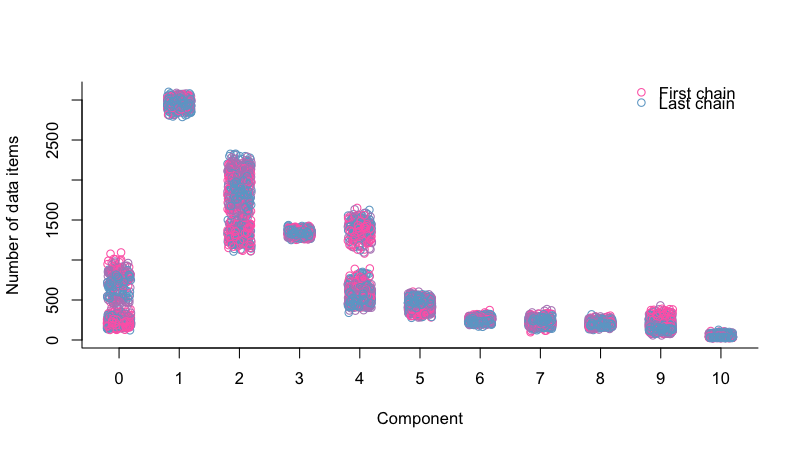

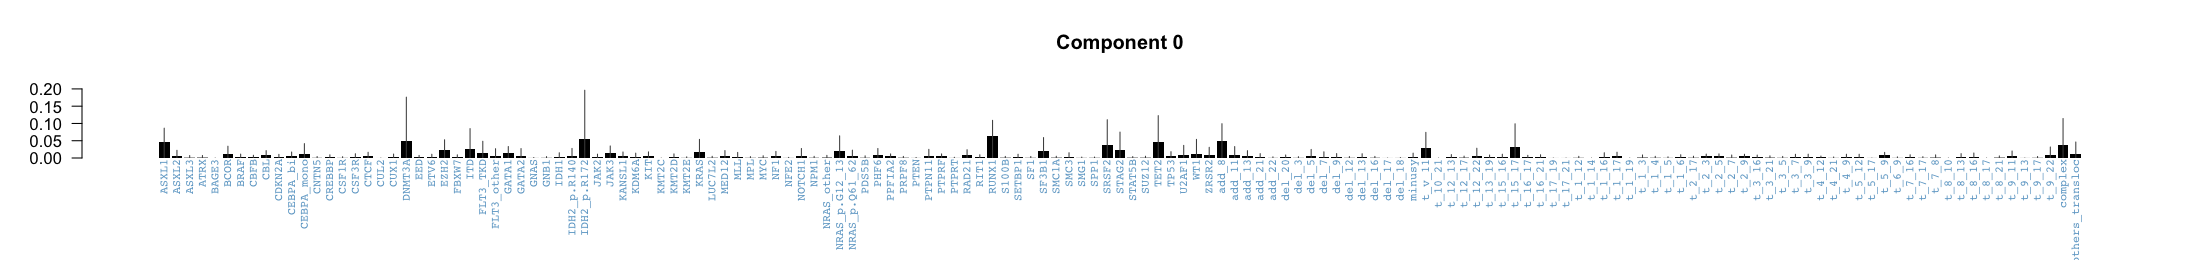

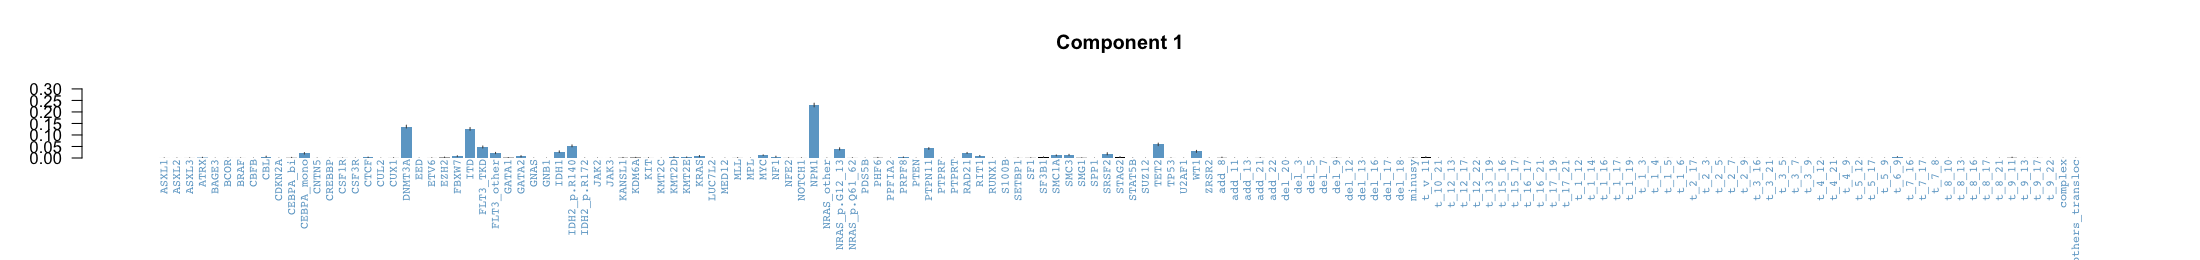

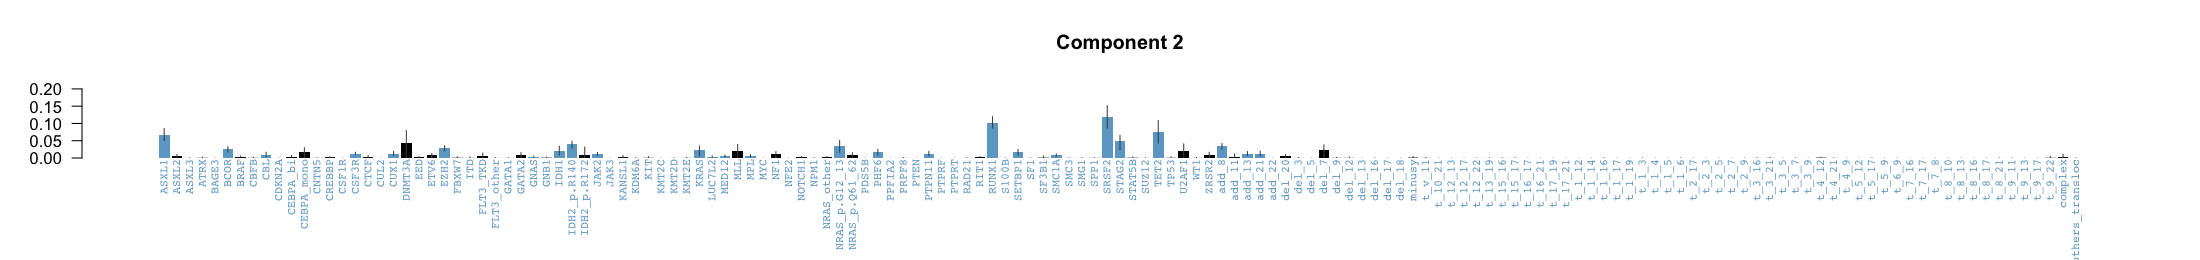

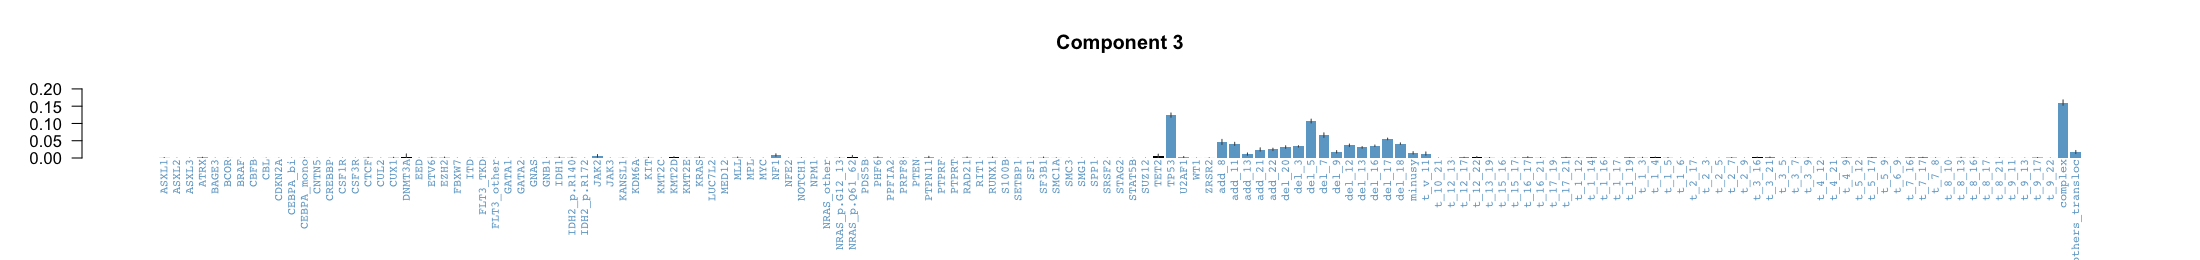

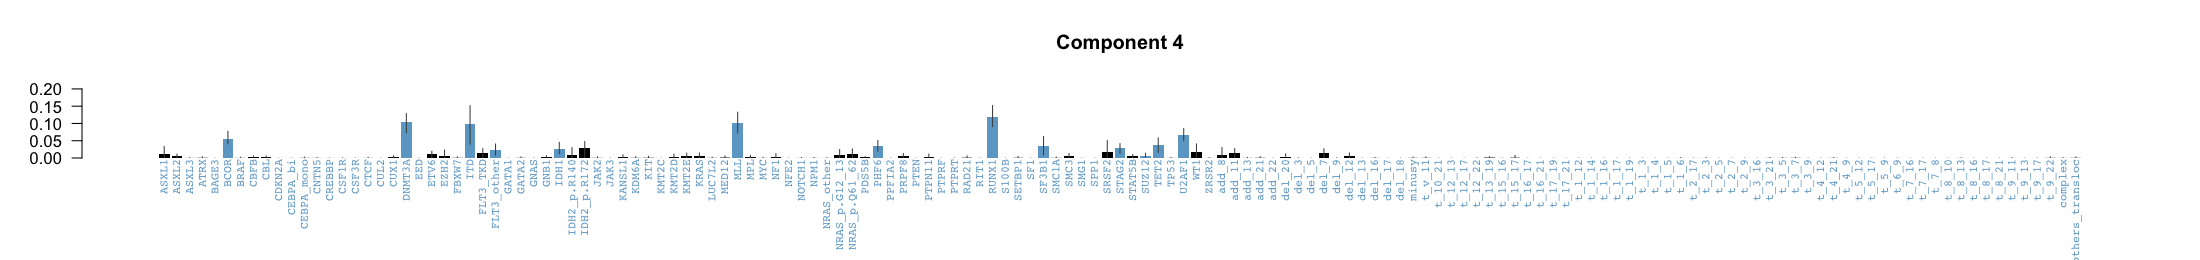

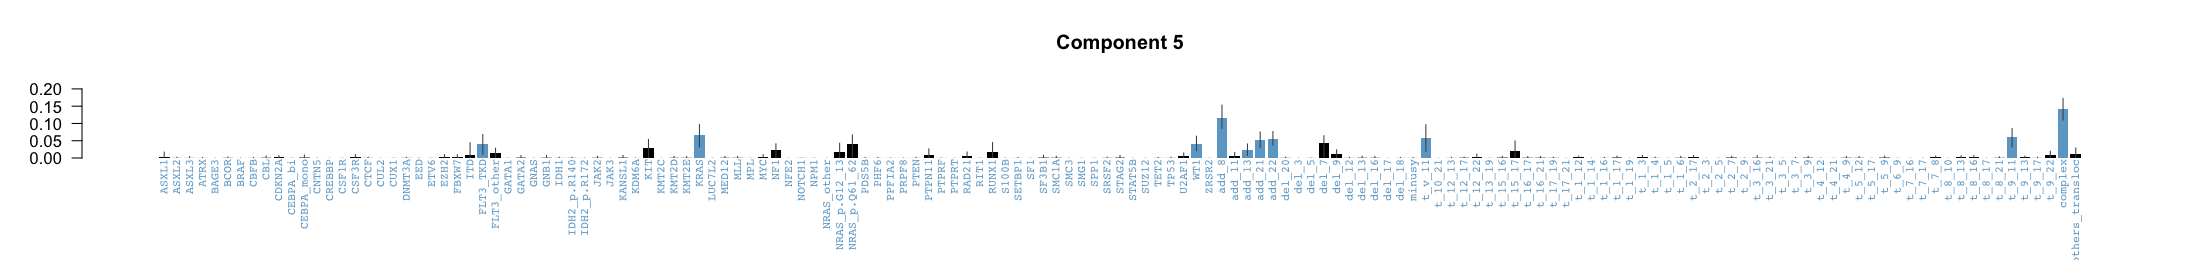

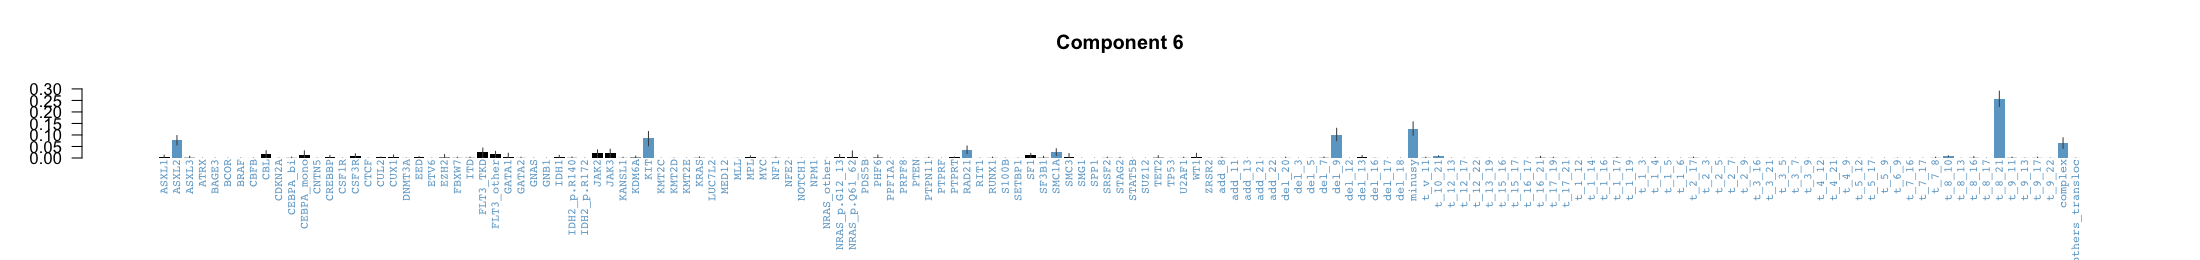

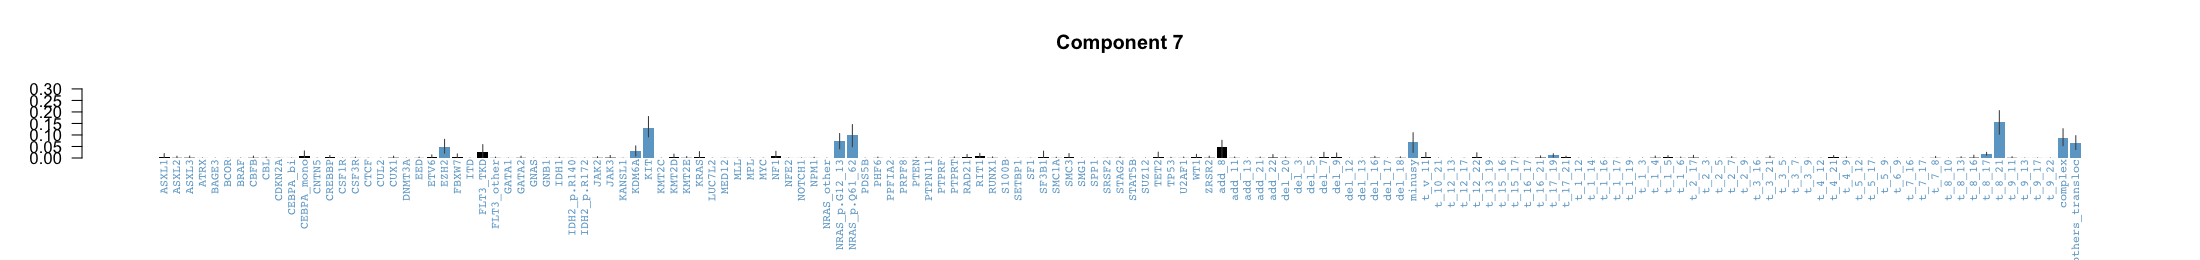

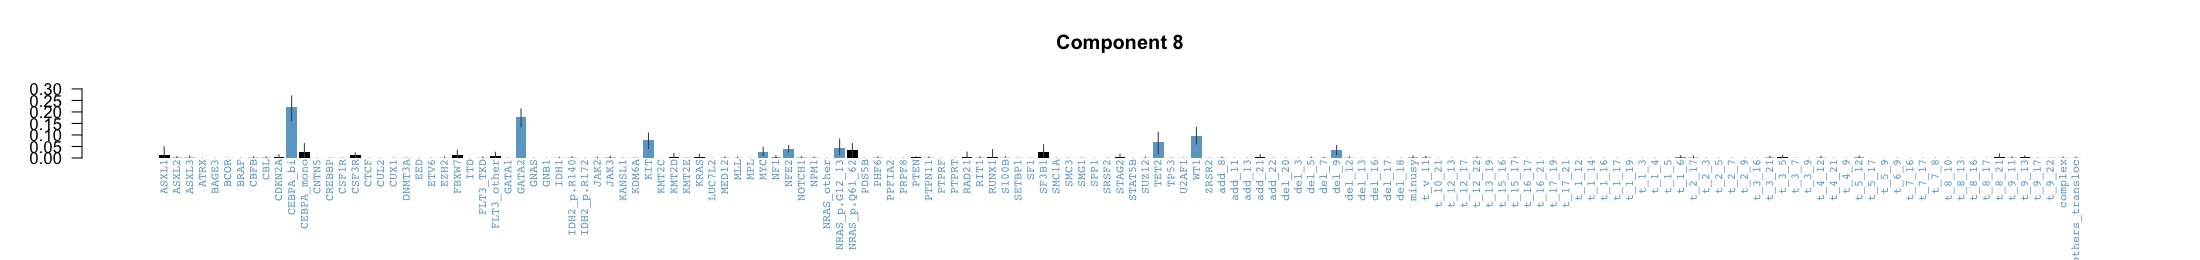

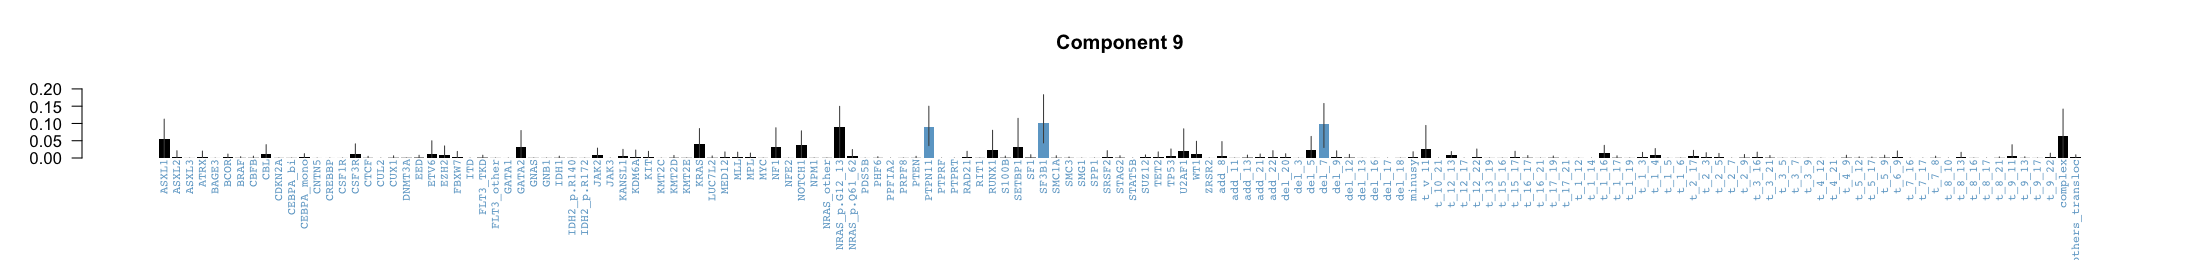

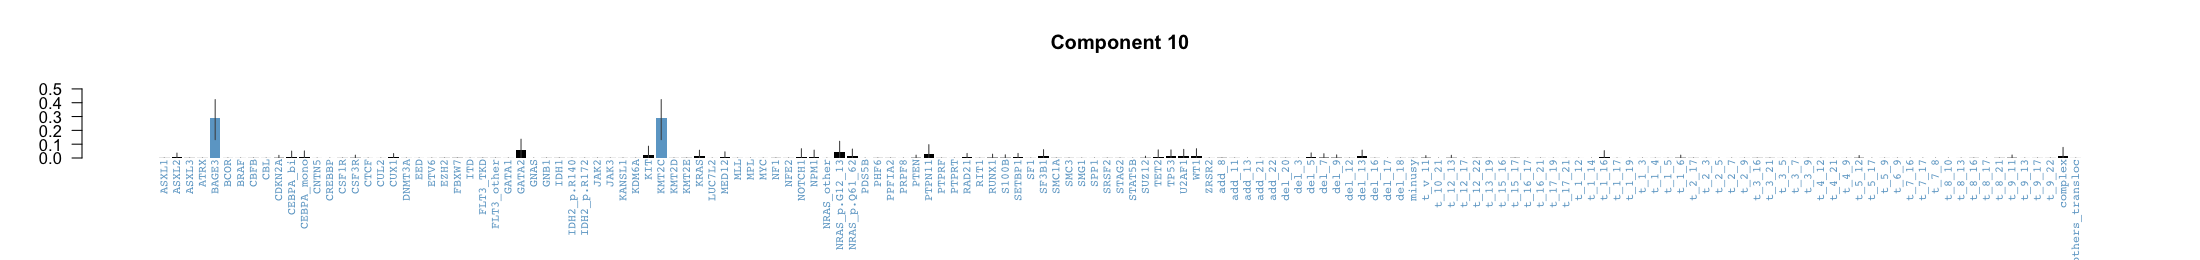

In [9]:
#plot_category_distribution_by_component(multi_output_cluster_10, colnames(df_final))
plot_components_size(multi_output_cluster_10,8,4.5)
set_notebook_plot_size(22, 2.6)
    plot_comp_distn(multi_output_cluster_10,
                    cat_names  = colnames(df_final),
                    col        = "skyblue3",
                    col_nonsig = "black",
                                         )

Number of components: 10
Number of NA rows   : 56


values      count freq             
2  1            851  39.5813953488372 
3  2            453  21.0697674418605 
4  3            224  10.4186046511628 
5  4            180  8.37209302325581 
6  5            136  6.32558139534884 
7  6             80  3.72093023255814 
8  7             62  2.88372093023256 
12 NaN           56  2.6046511627907  
9  8             48  2.23255813953488 
10 9             27  1.25581395348837 
1  0             25  1.16279069767442 
11 10             8  0.372093023255814
13 -- total -- 2150  100%

notch went outside hinges. Try setting notch=FALSE.


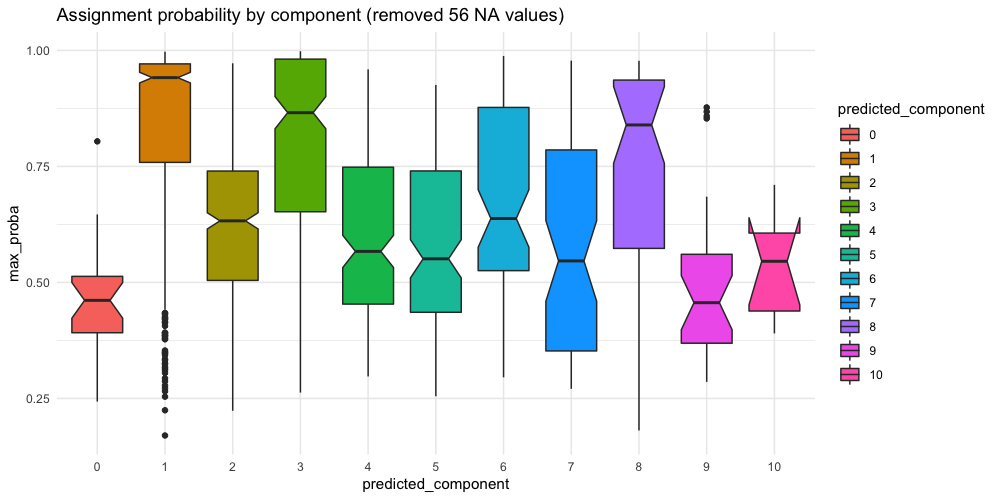

In [11]:
dd_predicted_10_components <- get_prediction_result_dataframe(multi_output_cluster_10, df_final)
get_table(dd_predicted_10_components[,'predicted_component'])
plot_assignement_probability_by_component(dd_predicted_10_components)

#### People assigned to NaN have no genetic and cytogenetic events (sum=0). We remove them from the analysis

In [66]:
initial_components <- cbind(df_final,add_first_second_predicted_component(multi_output_cluster_10))
sum(rowSums(initial_components[initial_components$predicted_component=="NaN",1:151]))


Number of components: 10
Number of NA rows   : 56


[1] 0

##### Create a dataframe with initial patients and their initial component (without NAN patients)

In [67]:

#write.table(initial_components,file="initial_components_with_proba.tsv",sep='\t')

# STEP 1: DEFINING FEATURES

In [192]:
tmp <- read.table("../finalization_clustering/all_components_with_second_complex_inv3.tsv") # introduce inv_3 for C7 Post Processing
tmp <- tmp[,c(1:150,155,156)]
tmp <- merge(tmp,read.table("initial_components_with_proba.tsv")[,152:166],by=0)
rownames(tmp)<- tmp$Row.names
tmp <- tmp[,-1]
tmp$initial_refined_component <- "not_assigned"
tmp[tmp$NPM1==1,]$initial_refined_component <- "NPM1"
tmp[tmp$initial_refined_component=="not_assigned" & (tmp$TP53==1 & tmp$complex==1),]$initial_refined_component <- "TP53_complex"
tmp[tmp$initial_refined_component=="not_assigned" & tmp$initial_predicted_component==3 & (tmp$TP53==1 | tmp$complex==1),]$initial_refined_component <- "TP53_complex"
tmp[tmp$initial_refined_component=="not_assigned" & tmp$initial_predicted_component==5 & (tmp$t_v_11==1 | tmp$t_9_11==1),]$initial_refined_component <- "t_11"
tmp[tmp$initial_refined_component=="not_assigned" & tmp$initial_predicted_component==5 & (tmp$t_15_17==1),]$initial_refined_component <- "t_15_17"
tmp[tmp$initial_refined_component=="not_assigned" & tmp$initial_predicted_component==6 & (tmp$t_8_21==1),]$initial_refined_component <- "t_8_21"
tmp[tmp$initial_refined_component=="not_assigned" & tmp$initial_predicted_component==7 & (tmp$t_8_21==1),]$initial_refined_component <- "t_8_21"
tmp[tmp$initial_refined_component=="not_assigned" & tmp$initial_predicted_component==8 & (tmp$CEBPA_bi==1),]$initial_refined_component <- "CEBPA_bi"
tmp[tmp$initial_refined_component=="not_assigned" & tmp$initial_predicted_component==9 & (tmp$inv_3==1),]$initial_refined_component <- "inv_3"
tmp[tmp$initial_refined_component=="not_assigned" & tmp$initial_predicted_component==10 & (tmp$BAGE3==1 & tmp$KMT2C==1),]$initial_refined_component <- "BAGE3_KMT2C"

In [193]:
table(tmp$initial_refined_component)


 BAGE3_KMT2C     CEBPA_bi        inv_3 not_assigned         NPM1         t_11 
           6           35            8         1010          682           53 
     t_15_17       t_8_21 TP53_complex 
           9           98          193 

# STEP 2: SECOND MAX PROBA + DEFINING FEATURES

In [194]:
min_proba_NPM1 = min(tmp[tmp$initial_predicted_component==1,]$max_proba)

min_proba_TP53_complex = min(tmp[tmp$initial_predicted_component==3,]$max_proba)

min_proba_transloc = min(tmp[tmp$initial_predicted_component==5,]$max_proba)

min_proba_t_8_21 = min(min(tmp[tmp$initial_predicted_component==6,]$max_proba),min(tmp[tmp$initial_predicted_component==7,]$max_proba))

min_proba_CEBPA_bi = min(tmp[tmp$initial_predicted_component==8,]$max_proba)

min_proba_inv_3 = min(tmp[tmp$initial_predicted_component==9,]$max_proba)

min_proba_BAGE3_KMT2C = min(tmp[tmp$initial_predicted_component==10,]$max_proba)



In [195]:
tmp[tmp$initial_refined_component=="not_assigned" & !is.element(tmp$initial_refined_component=="not_assigned",c(0,2,4)) ,]$initial_refined_component  <- apply(tmp[tmp$initial_refined_component=="not_assigned" & !is.element(tmp$initial_refined_component=="not_assigned",c(0,2,4)),], 1,function(x) {
        if (all(is.na(x['second_predicted_component'])))
            return(NaN)
        else 
            return(ifelse(x['second_predicted_component']==3 & x['second_max_proba']>=0.75*min_proba_TP53_complex & (x['complex']==1 | x["TP53"]==1),"TP53_complex",
                   ifelse(x['second_predicted_component']==5 & x['second_max_proba']>=0.75*min_proba_transloc & (x['t_v_11']==1 | x['t_9_11']==1),"t_11",
                   ifelse(x['second_predicted_component']==5 & x['second_max_proba']>=0.75*min_proba_transloc & x['t_15_17']==1,"t_15_17", 
                   ifelse((x['second_predicted_component']==6 | x['translated_second_predicted_component']==7 ) & x['second_max_proba']>=0.75*min_proba_t_8_21 & x['t_8_21']==1,"t_8_21", 
                   ifelse(x['second_predicted_component']==8 & x['second_max_proba']>=0.75*min_proba_CEBPA_bi & x['CEBPA_bi']==1,"CEBPA_bi",
                   ifelse(x['second_predicted_component']==9 & x['second_max_proba']>=0.75*min_proba_inv_3 & x['inv_3']==1,"inv_3",
                   ifelse(x['second_predicted_component']==10 & x['second_max_proba']>=0.75*min_proba_BAGE3_KMT2C & x['BAGE3']==1 & x['KMT2C']==1,"BAGE3_KMT2C",       
                   "not_assigned"))))))))
    })

# Let's reapply HDP to patients from Initial Component 0,2,4 + patients that do not have defining features from their component and that were not assigned with second max proba (658 from C 0,2,4 and 318 from defining features +second max proba)

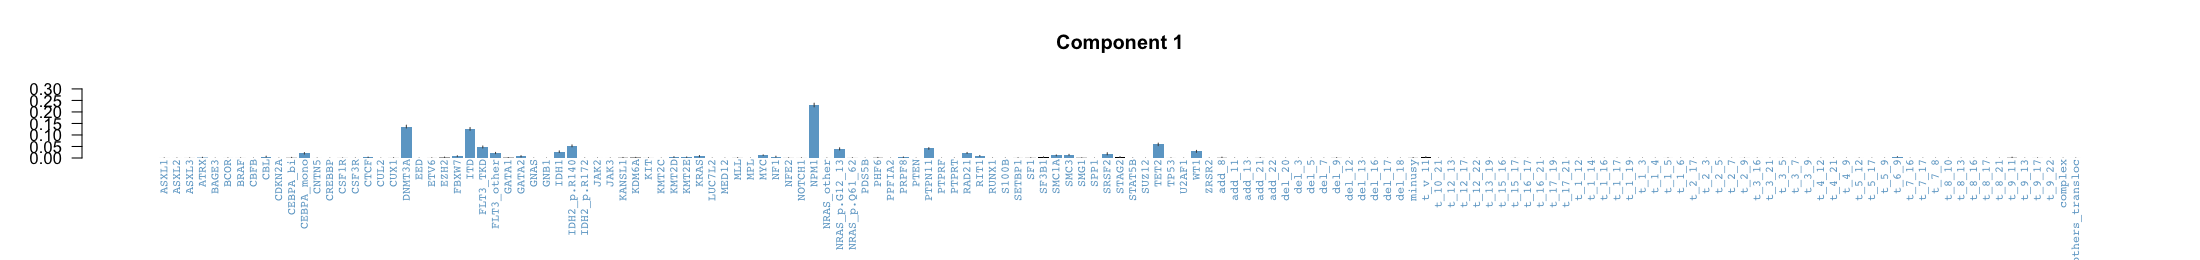

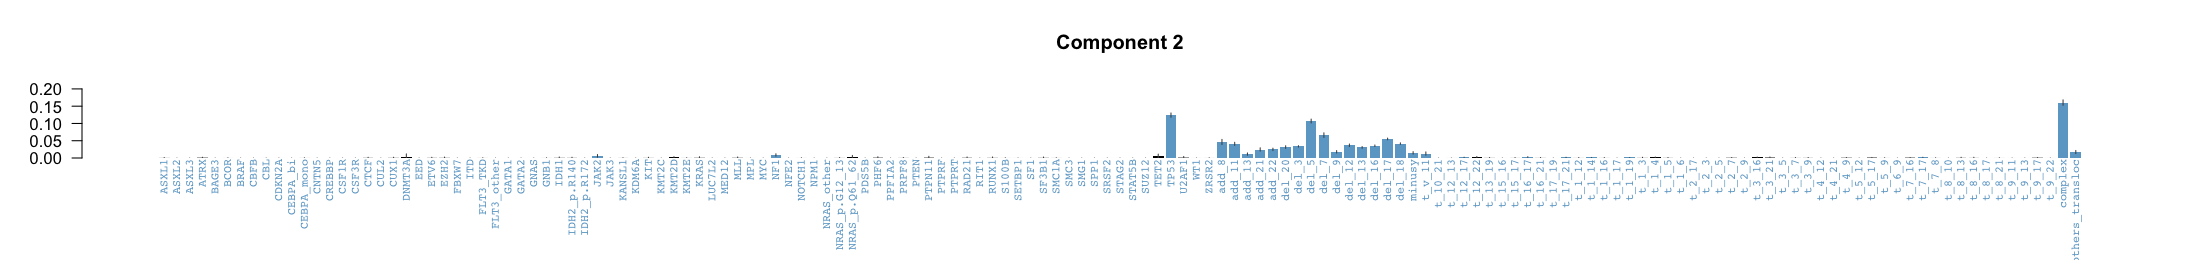

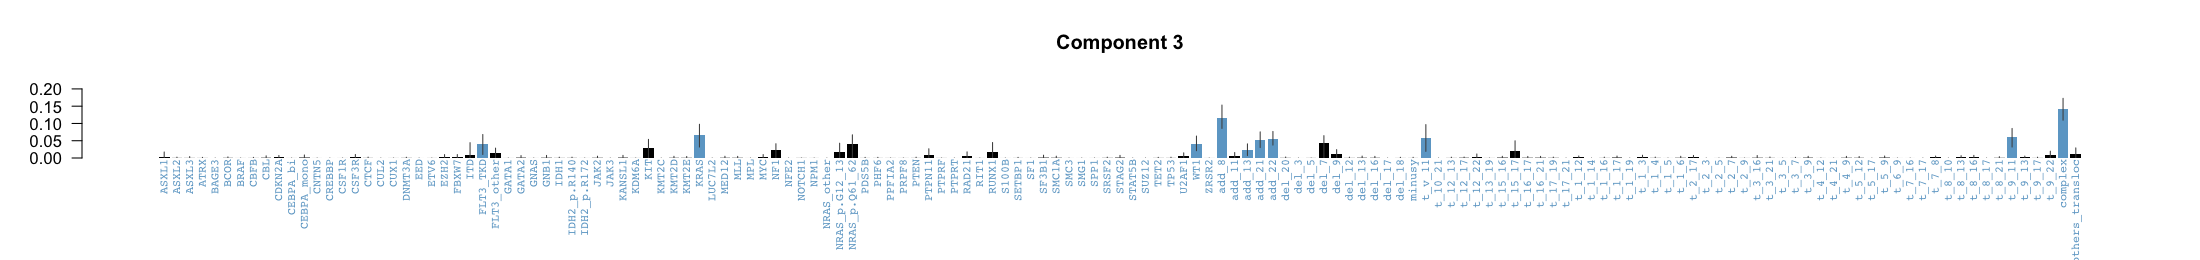

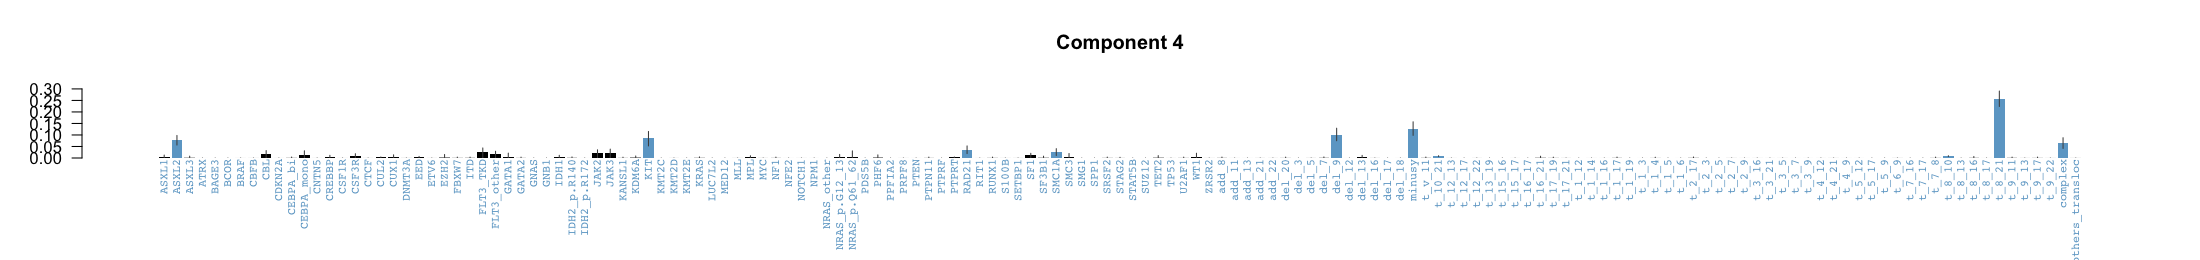

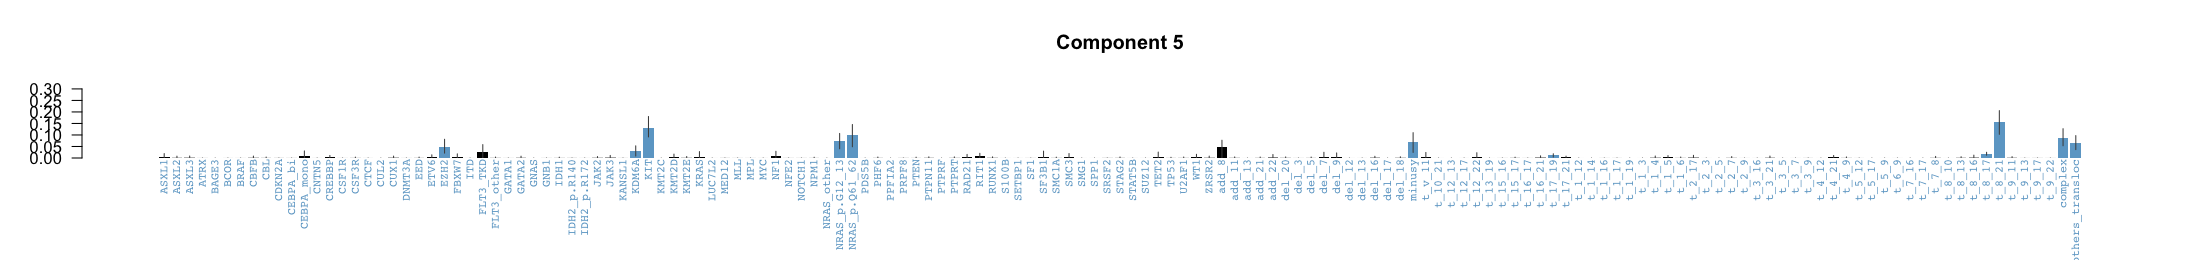

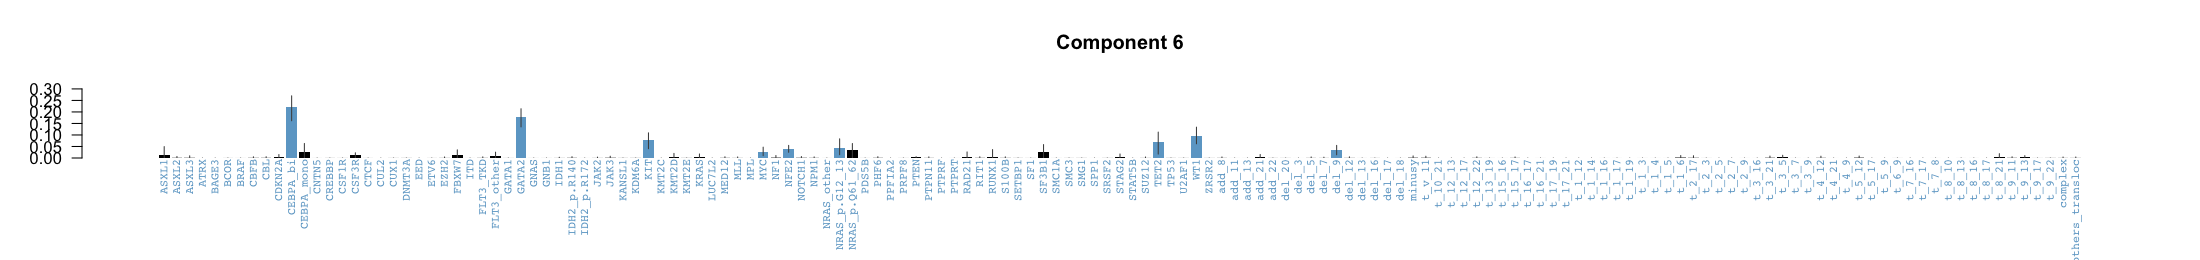

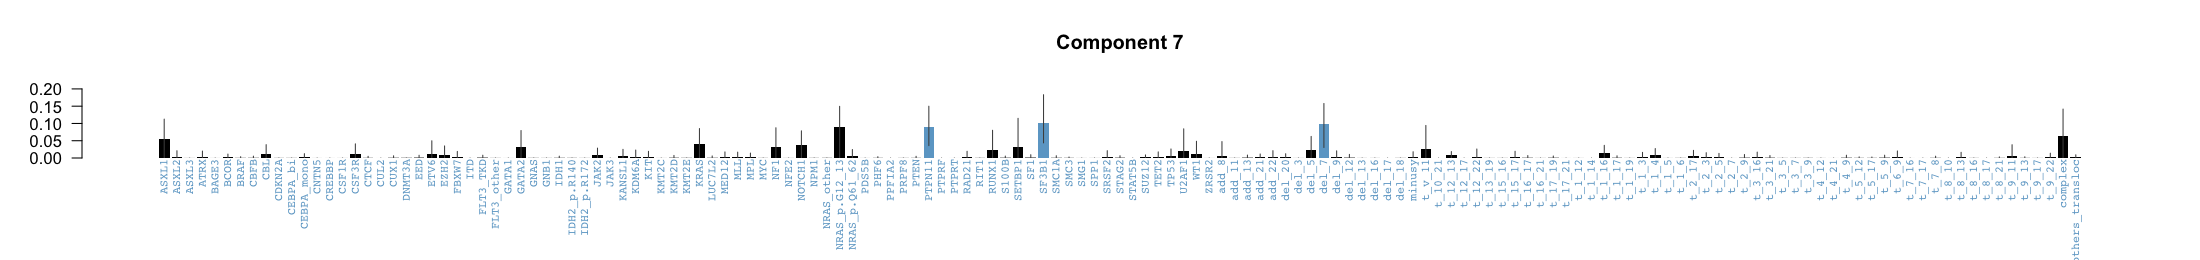

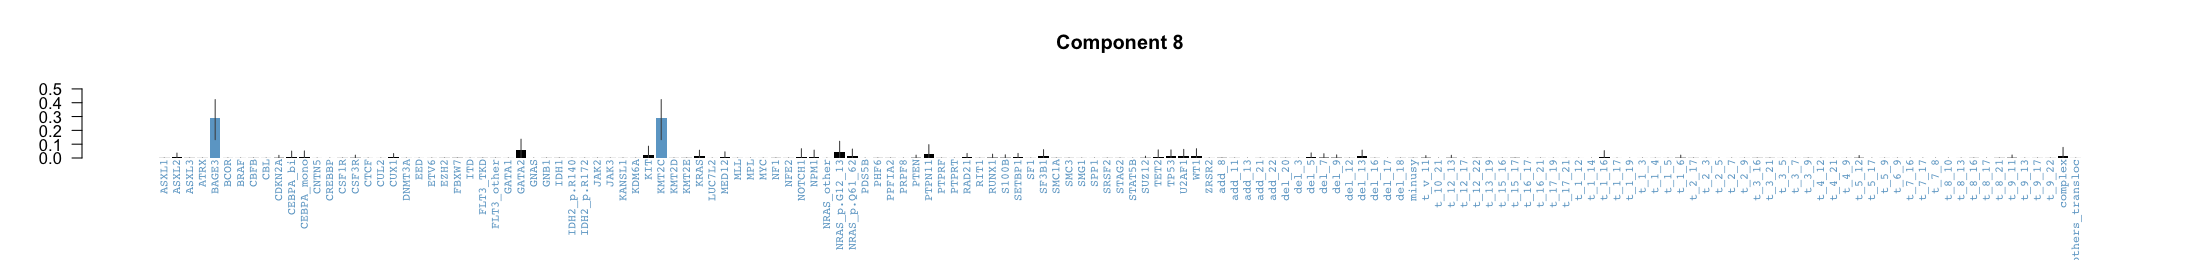

In [196]:
set_notebook_plot_size(22, 2.6)
    plot_comp_distn(multi_output_cluster_10,
                    cat_names  = colnames(df_final),
                    col        = "skyblue3",
                    col_nonsig = "black",
                    comp=c(1,3,5,6,7,8,9,10),
                    plot_title=c("Component 1","Component 2","Component 3","Component 4","Component 5","Component 6","Component 7","Component 8")
                                         )

# II- HDP reapplied ON THOSE PATIENTS

In [197]:
# ADD U2AF1 Separation

In [210]:
colnames(tmp_u2af1
    )

[1] "ASXL1"           "ASXL2"           "ASXL3"           "ATRX"           
  [5] "BAGE3"           "BCOR"            "BRAF"            "CBFB"           
  [9] "CBL"             "CDKN2A"          "CEBPA_bi"        "CEBPA_mono"     
 [13] "CNTN5"           "CREBBP"          "CSF1R"           "CSF3R"          
 [17] "CTCF"            "CUL2"            "CUX1"            "DNMT3A"         
 [21] "EED"             "ETV6"            "EZH2"            "FBXW7"          
 [25] "ITD"             "FLT3_TKD"        "FLT3_other"      "GATA1"          
 [29] "GATA2"           "GNAS"            "GNB1"            "IDH1"           
 [33] "IDH2_p.R140"     "IDH2_p.R172"     "JAK2"            "JAK3"           
 [37] "KANSL1"          "KDM6A"           "KIT"             "KMT2C"          
 [41] "KMT2D"           "KMT2E"           "KRAS"            "LUC7L2"         
 [45] "MED12"           "MLL"             "MPL"             "MYC"            
 [49] "NF1"             "NFE2"            "NOTCH1"          "NPM1"           
 [53] "NRAS_other"      "NRAS_p.G12_13"   "NRAS_p.Q61_62"   "PDS5B"          
 [57] "PHF6"            "PPFIA2"          "PRPF8"           "PTEN"           
 [61] "PTPN11"          "PTPRF"           "PTPRT"           "RAD21"          
 [65] "RIT1"            "RUNX1"           "S100B"           "SETBP1"         
 [69] "SF1"             "SF3B1"           "SMC1A"           "SMC3"           
 [73] "SMG1"            "SPP1"            "SRSF2"           "STAG2"          
 [77] "STAT5B"          "SUZ12"           "TET2"            "TP53"           
 [81] "U2AF1_p.S34"     "U2AF1_p.Q157"    "WT1"             "ZRSR2"          
 [85] "add_8"           "add_11"          "add_13"          "add_21"         
 [89] "add_22"          "del_20"          "del_3"           "del_5"          
 [93] "del_7"           "del_9"           "del_12"          "del_13"         
 [97] "del_16"          "del_17"          "del_18"          "minusy"         
[101] "t_v_11"          "t_10_21"         "t_12_13"         "t_12_17"        
[105] "t_12_22"         "t_13_19"         "t_15_16"         "t_15_17"        
[109] "t_16_17"         "t_16_21"         "t_17_19"         "t_17_21"        
[113] "t_1_12"          "t_1_14"          "t_1_16"          "t_1_17"         
[117] "t_1_19"          "t_1_3"           "t_1_4"           "t_1_5"          
[121] "t_1_6"           "t_2_17"          "t_2_3"           "t_2_5"          
[125] "t_2_7"           "t_2_9"           "t_3_16"          "t_3_21"         
[129] "t_3_5"           "t_3_7"           "t_3_9"           "t_4_12"         
[133] "t_4_21"          "t_4_9"           "t_5_12"          "t_5_17"         
[137] "t_5_9"           "t_6_9"           "t_7_16"          "t_7_17"         
[141] "t_7_8"           "t_8_10"          "t_8_13"          "t_8_16"         
[145] "t_8_17"          "t_8_21"          "t_9_11"          "t_9_13"         
[149] "t_9_17"          "t_9_22"          "others_transloc" "complex"

In [222]:
df <- read.table("../../../data/initial_dataset/1013.mut.csv",sep=',', header = T)
df <- df[df$gene=="U2AF1",c("data_pd","gene","protein")]
df$U2AF1_p.S34 <- ifelse(grepl( "34",df$protein) | grepl( "35",df$protein),1,0)
df$U2AF1_p.Q157 <- ifelse(grepl( "157",df$protein) | grepl( "156",df$protein),1,0)
df <- unique(df,by="data_pd")
newd <-  df %>% group_by(data_pd) %>% filter(n()>1)
tmp1 <- data.frame(data_pd=unique(newd$data_pd),gene=rep("U2AF1",length(unique(newd$data_pd))),protein=rep("p",length(unique(newd$data_pd))),U2AF1_p.S34=rep(0,length(unique(newd$data_pd))),U2AF1_p.Q157=rep(0,length(unique(newd$data_pd))))
for (element in unique(newd$data_pd)){    
    tmp1[tmp1$data_pd==element,]$U2AF1_p.S34 <- colSums(newd[newd$data_pd==element,"U2AF1_p.S34"])
    tmp1[tmp1$data_pd==element,]$U2AF1_p.Q157 <- colSums(newd[newd$data_pd==element,"U2AF1_p.Q157"])
}
df <- rbind(df[!is.element(df$data_pd,unique(newd$data_pd)),c("data_pd","U2AF1_p.S34","U2AF1_p.Q157","protein")],tmp1[,c("data_pd","U2AF1_p.S34","U2AF1_p.Q157","protein")])
rownames(df)<- df$data_pd
df_u2af1 <- df[,c("U2AF1_p.S34","U2AF1_p.Q157")]
#dim(df_u2af1)
tmp_u2af1 <- merge(tmp,df_u2af1,by=0,all.x=T)
rownames(tmp_u2af1) <- tmp_u2af1$Row.names
tmp_u2af1 <- tmp_u2af1[,c(2:81,170,171,83:152,169)]
tmp_u2af1[is.na(tmp_u2af1)] <- 0
#colnames(tmp_u2af1 )
#dim(merge(tmp,df_u2af1,by=0)[,c("U2AF1","U2AF1_p.S34","U2AF1_p.Q157")])

In [224]:
df_to_recluster <- tmp[tmp$initial_refined_component=="not_assigned",c(1:149,151,150)] # to keep same order as first HDP and remove complex
df_to_recluster <- tmp_u2af1[tmp_u2af1$initial_refined_component=="not_assigned",c(1:150,152,151)]
#colnames(df_to_recluster)

In [229]:
#write.table(df_to_recluster,"df_to_recluster.tsv")

In [225]:
num_cols = ncol(df_to_recluster[colSums(df_to_recluster) > 0])  ## keep only column that have at least a mutation
num_cols
bin <- function(x){
    set.seed(123)
  (rbinom(1, num_cols, mean(x))+1)/num_cols
}

###Normal

normal <- function(x){
    set.seed(123)
  abs(rnorm(1,mean(x),sd(x)))
}

###Poisson

poisson <- function(x){
    set.seed(123)
  (rpois(num_cols,1)+1)/num_cols
}

###Uniform equally over all columns

equally <- function(x){
    set.seed(123)
  1/num_cols
}

###Repet 1

repet <- function(x){
    set.seed(123)
  1
}

binomial <- unlist(sapply(df_to_recluster[colSums(df_to_recluster) > 0],bin))
gaussian <- unlist(sapply(df_to_recluster[colSums(df_to_recluster) > 0],normal))
pois <- as.numeric(unlist(sapply(df_to_recluster[colSums(df_to_recluster) > 0],poisson)))
unif <- unlist(sapply(df_to_recluster[colSums(df_to_recluster) > 0],equally))

[1] 132

In [226]:
data <- df_to_recluster[colSums(df_to_recluster) > 0]
posterior_samples <- 150
initial_clusters <- 5
burn <- 5000
chains <- 3
base_dist <- gaussian
aa <- 1
ab <-1
multi_output <- launch(df_to_recluster[colSums(df_to_recluster) > 0],base_dist,initial_clusters,burn,posterior_samples,chains,aa,ab)
multi_output_recluster_7 <- extract_components(multi_output)


Initialise HDP on a 974 x 132 dataframe
  → create HDP structure... done!
  → add DP node for each patient... done!
  → assign the data to the nodes... done!
### Experiment 1 (seed = 100) ###
Activate HDP nodes and run posterior sampling
  → activate HDP nodes... done!
  → run posterior sampling...
[1] "5000 burn-in iterations in 0.2 mins"

### Experiment 2 (seed = 200) ###
Activate HDP nodes and run posterior sampling
  → activate HDP nodes... done!
  → run posterior sampling...
[1] "5000 burn-in iterations in 0.2 mins"

### Experiment 3 (seed = 300) ###
Activate HDP nodes and run posterior sampling
  → activate HDP nodes... done!
  → run posterior sampling...
[1] "5000 burn-in iterations in 0.2 mins"

Object of class hdpSampleMulti 
 Number of chains: 3 
 Total posterior samples: 450 
 Components: NO. Run hdp_extract_components 
 ----------
 Final hdpState from first chain: 
Object of class hdpState 
 Number of DP nodes: 975 
 Index of parent DP: 0 1 1 1 1 1 1 1 1 1 ...
 Number of da

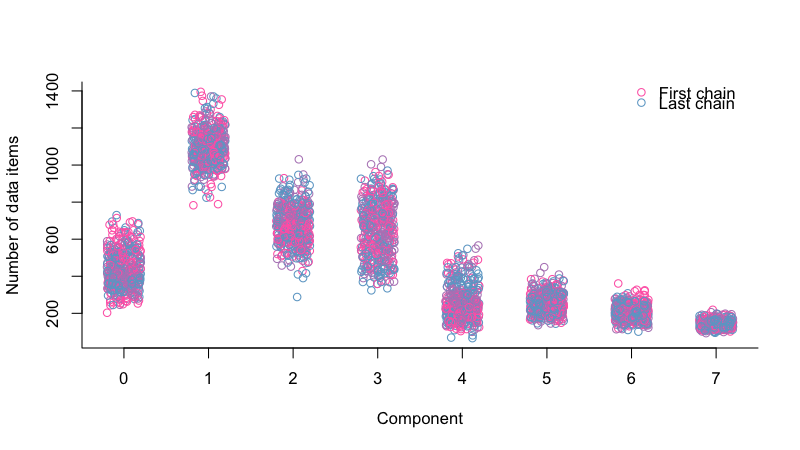

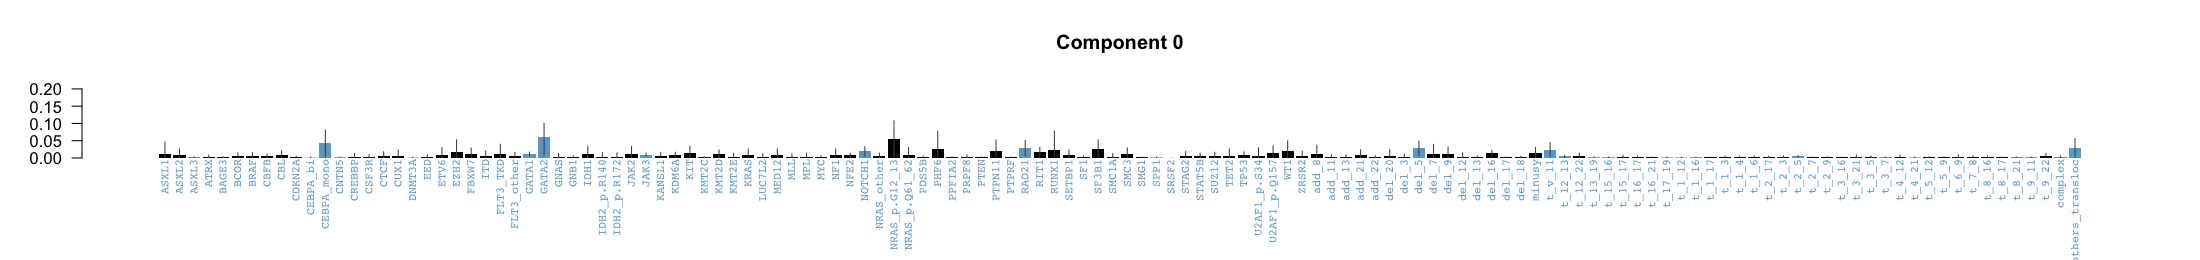

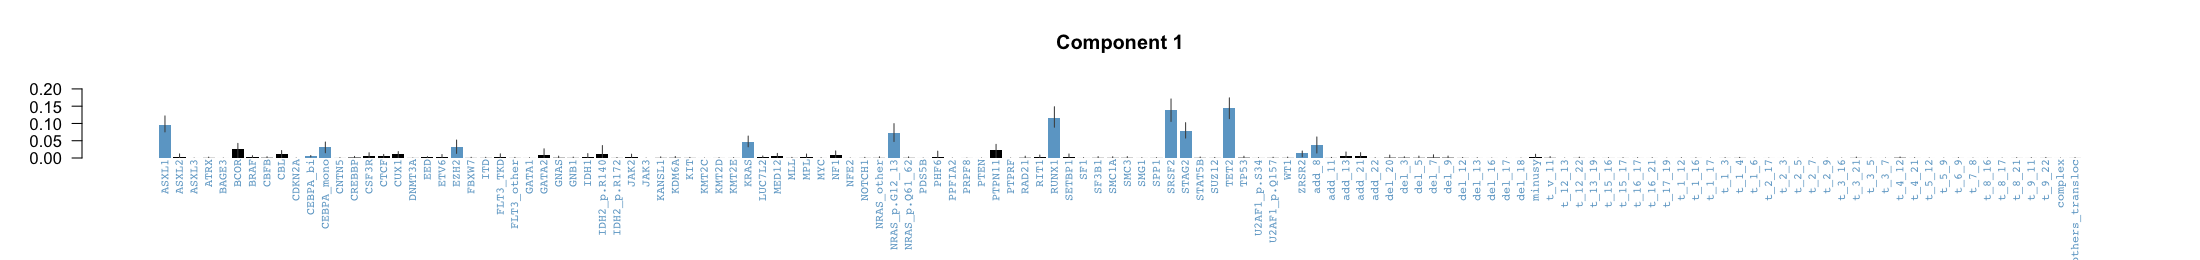

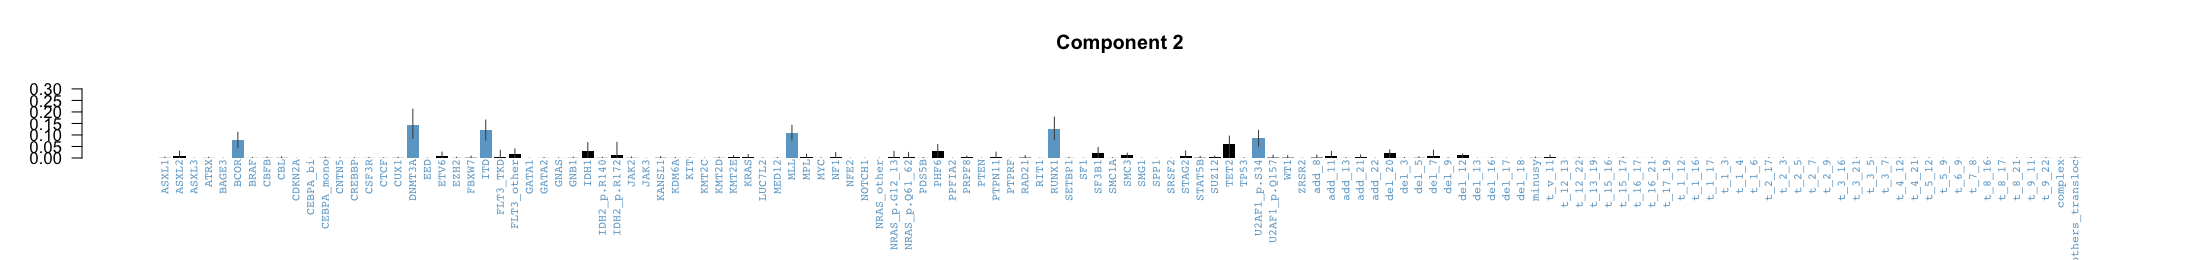

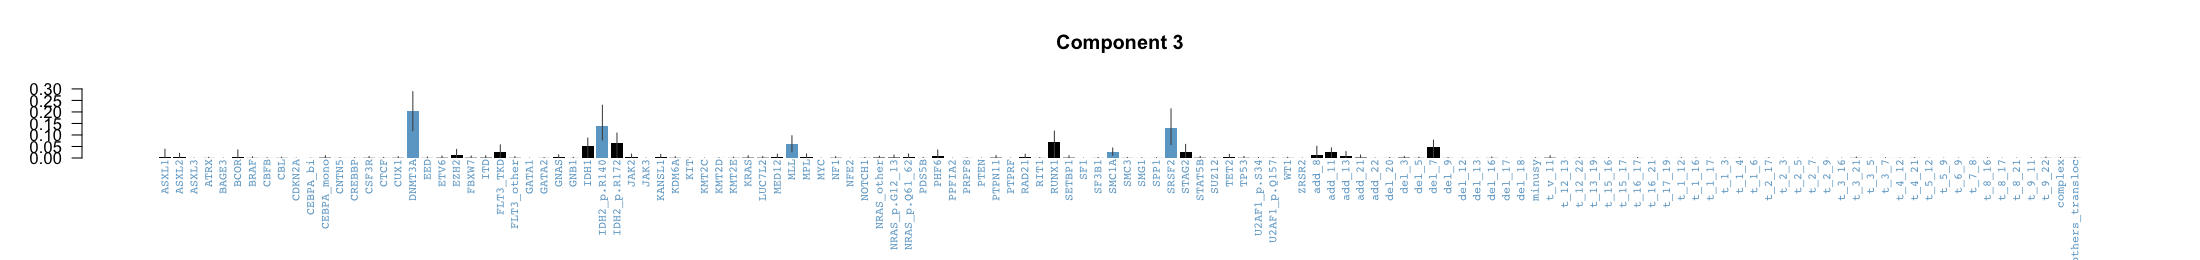

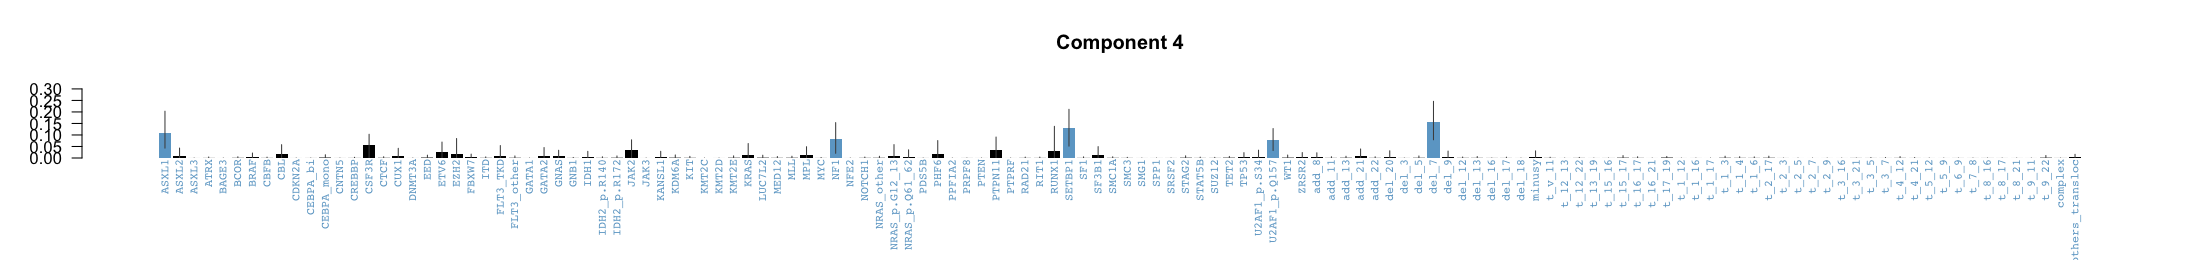

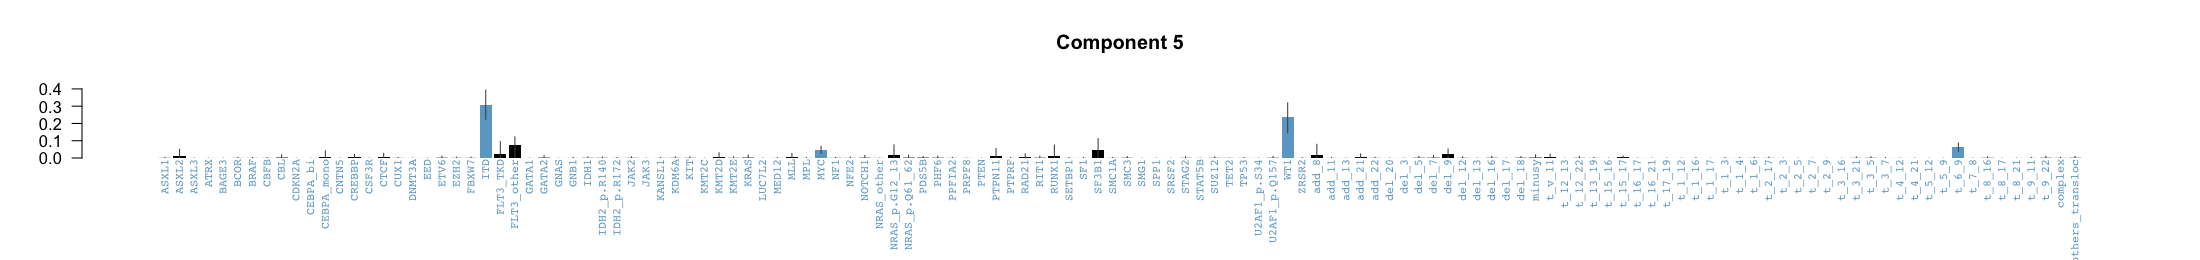

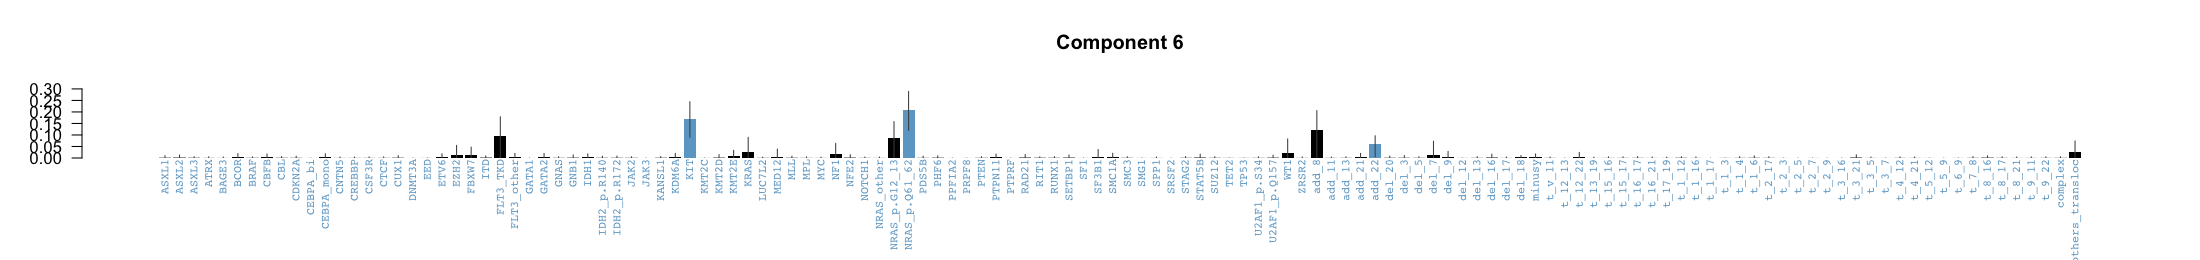

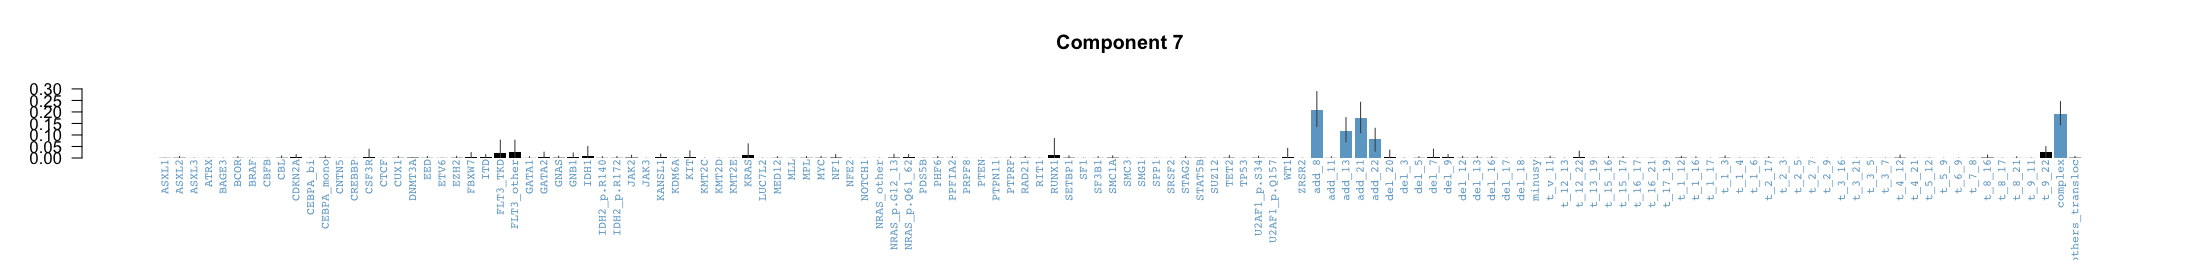

In [227]:
plot_components_size(multi_output_recluster_7,8,4.5)
set_notebook_plot_size(22,2.6)
plot_comp_distn(multi_output_recluster_7,
                    cat_names  = colnames(df_to_recluster[colSums(df_to_recluster) > 0]),
                    col        = "skyblue3",
                    col_nonsig = "black")



Number of components: 7
Number of NA rows   : 3


values      count freq             
2  1           291   29.8767967145791 
4  3           185   18.993839835729  
3  2           171   17.5564681724846 
1  0           106   10.8829568788501 
6  5            75   7.70020533880903 
7  6            71   7.28952772073922 
5  4            44   4.51745379876797 
8  7            28   2.87474332648871 
9  NaN           3   0.308008213552361
11 -- total -- 974   100%

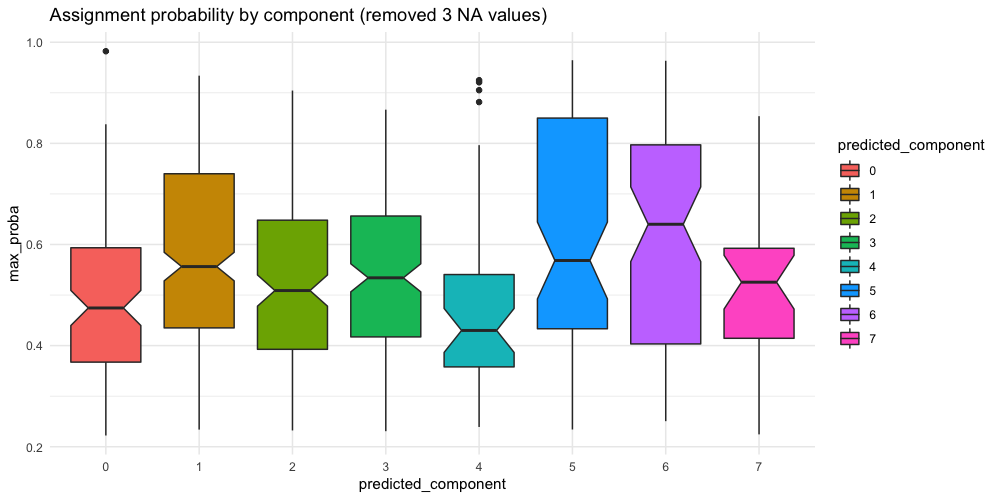

In [228]:
dd_predicted_recluster_7 <- get_prediction_result_dataframe(multi_output_recluster_7, df_to_recluster[colSums(df_to_recluster) > 0])
get_table(dd_predicted_recluster_7[,'predicted_component'])
plot_assignement_probability_by_component(dd_predicted_recluster_7)

#Let's look at the repartition of initial component 0,2 and 4 in their new HDP Clustering : new component 1 to 7

In [141]:
df_10_component <- cbind(df_final, dd_predicted_10_components)
df_7_component <- df_10_component[df_10_component$predicted_component == 0 | df_10_component$predicted_component == 2 | df_10_component$predicted_component == 4 ,]
df_7_component$predicted_old_component <- df_7_component$predicted_component
df_7_component <- df_7_component['predicted_old_component']
df_7_component <- na.omit(df_7_component)
tmp <- cbind(df_7_component, dd_predicted_recluster_7['predicted_component'])

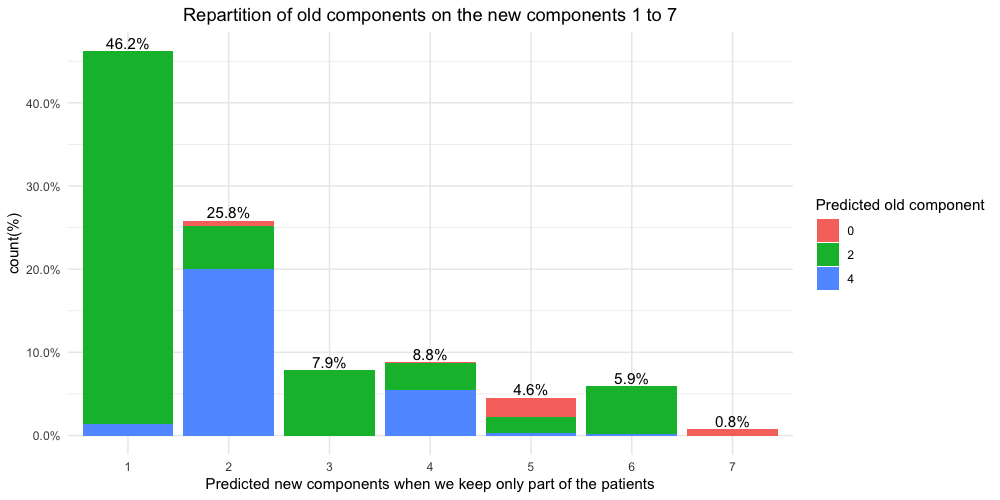

In [142]:
ggplot(tmp, aes(predicted_component)) +
geom_bar(aes(y = (..count..)/sum(..count..),fill=factor(predicted_old_component)))+
geom_text(aes(y = ((..count..)/sum(..count..)), label = scales::percent((..count..)/sum(..count..))), stat = "count", vjust = -0.25) +
scale_y_continuous(labels = percent) +
labs(x = "Predicted new components when we keep only part of the patients",title="Repartition of old components on the new components 1 to 7",fill="Predicted old component",y="count(%)")+
theme(plot.title = element_text(hjust = 0.5))

## Summary : 
#### We initially started with component 0 to 10 : C0 to C10 .
#### We removed component 0,2 and 4. It means that we now have C1 to C8 with C1 is initial component 1 , C2 is initial component 3, C3 is initial component 5 , C4 is initial component 6 , C5 initial
#### component 7, C6 initial component 8, C7 initial component 9 , C8 initial component 10.
#### On component 0,2 and 4 : we apply new HDP clustering (above) in order to create a repartition of those components into 7 new component (NC1 to NC7).
#### Therefore, we now have : C1 ... C8 and NC1 ... NC7

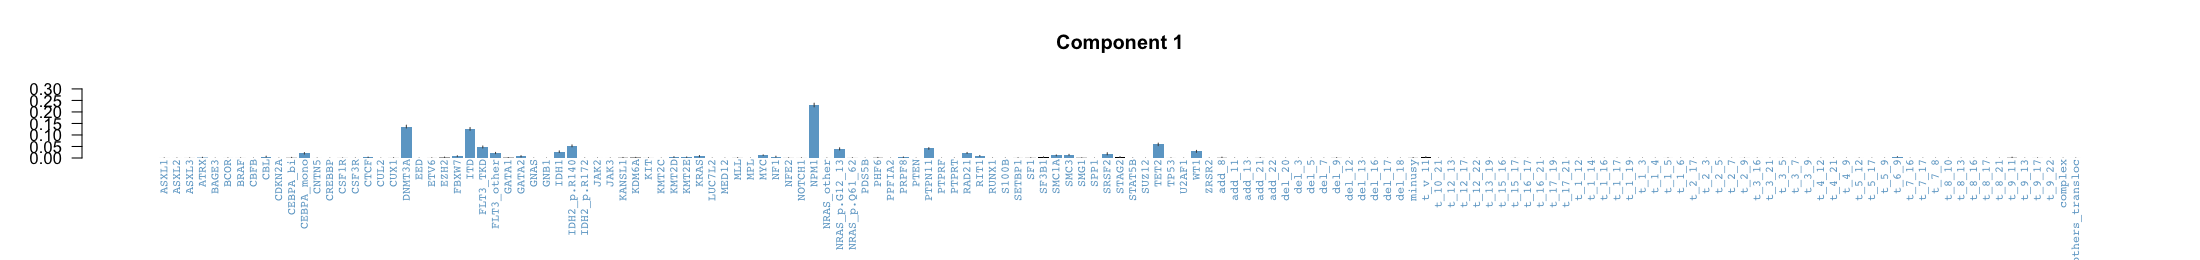

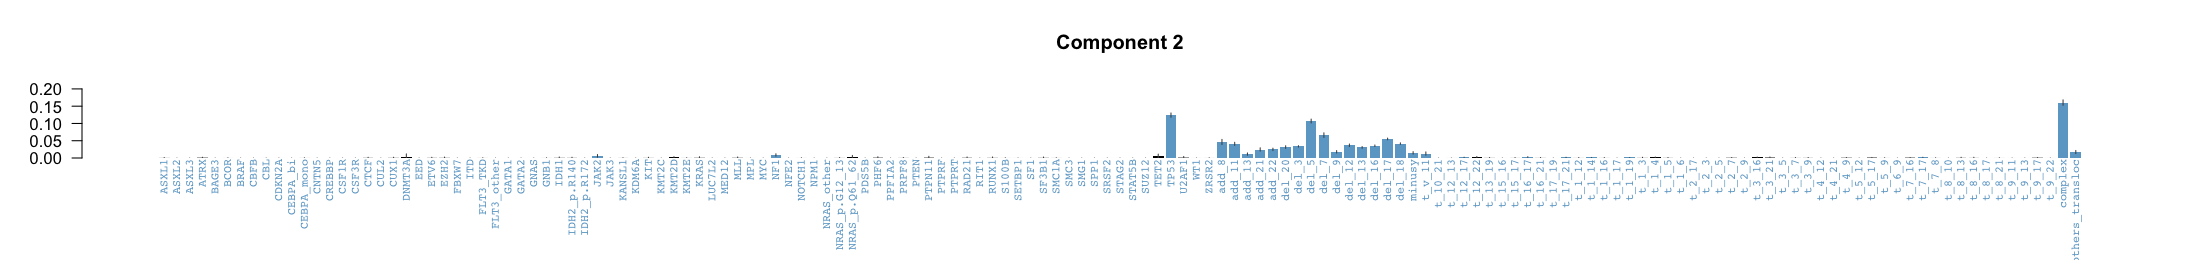

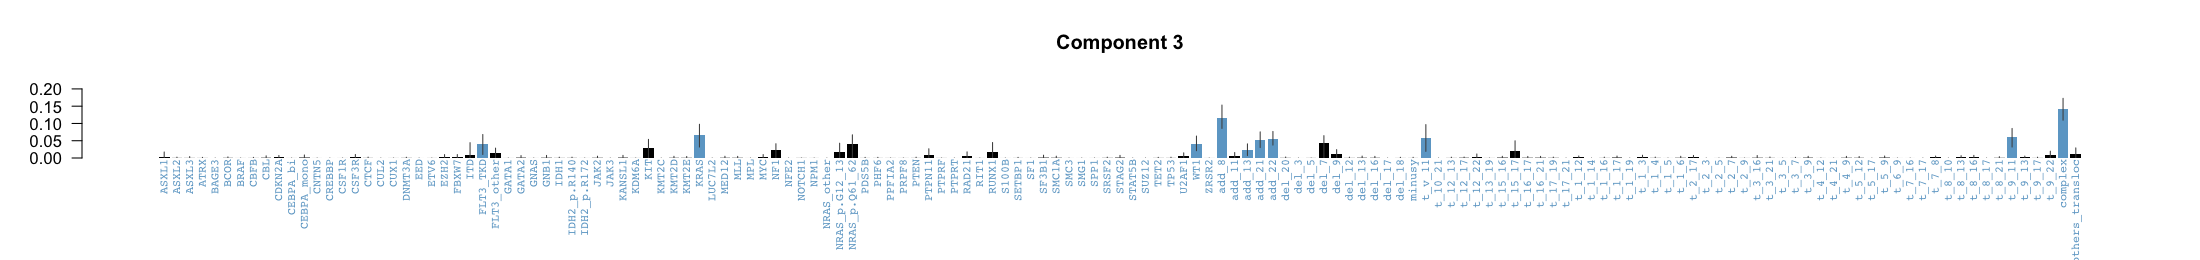

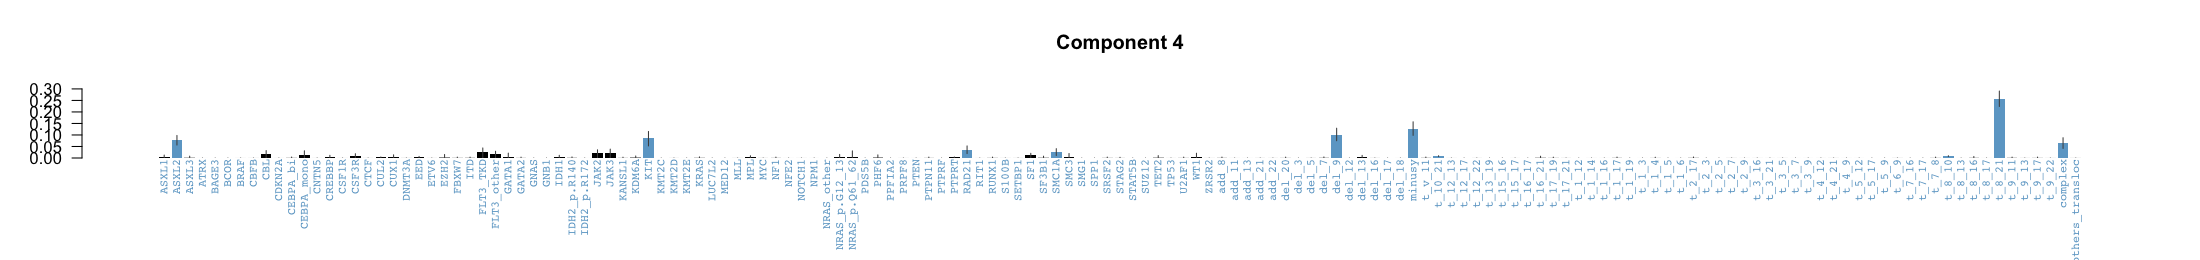

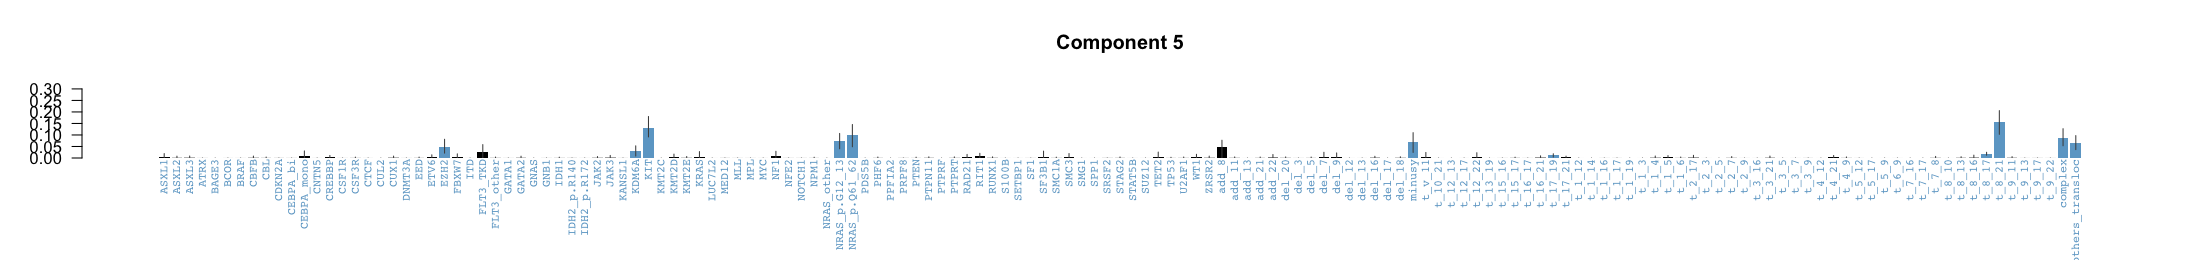

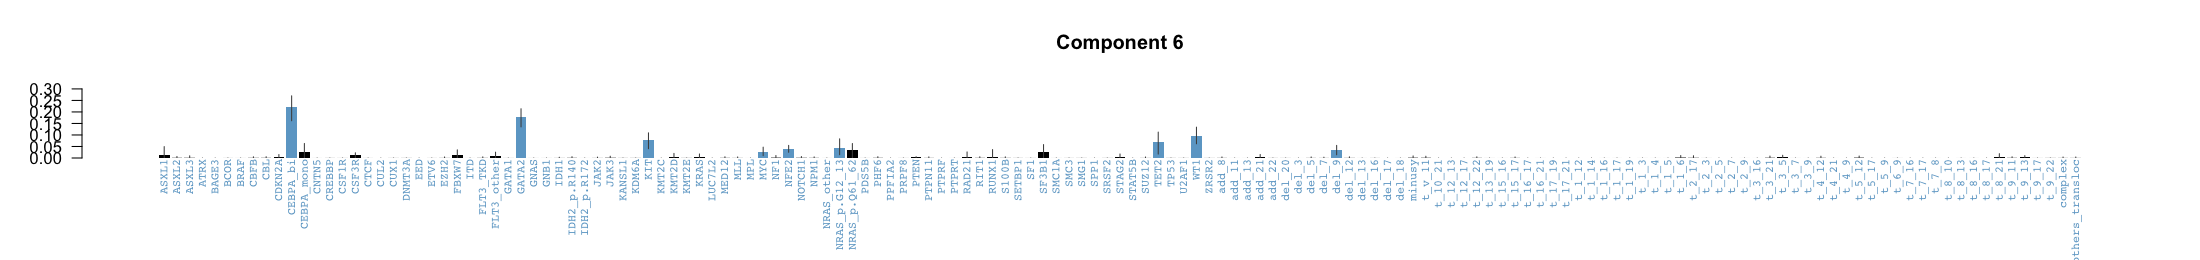

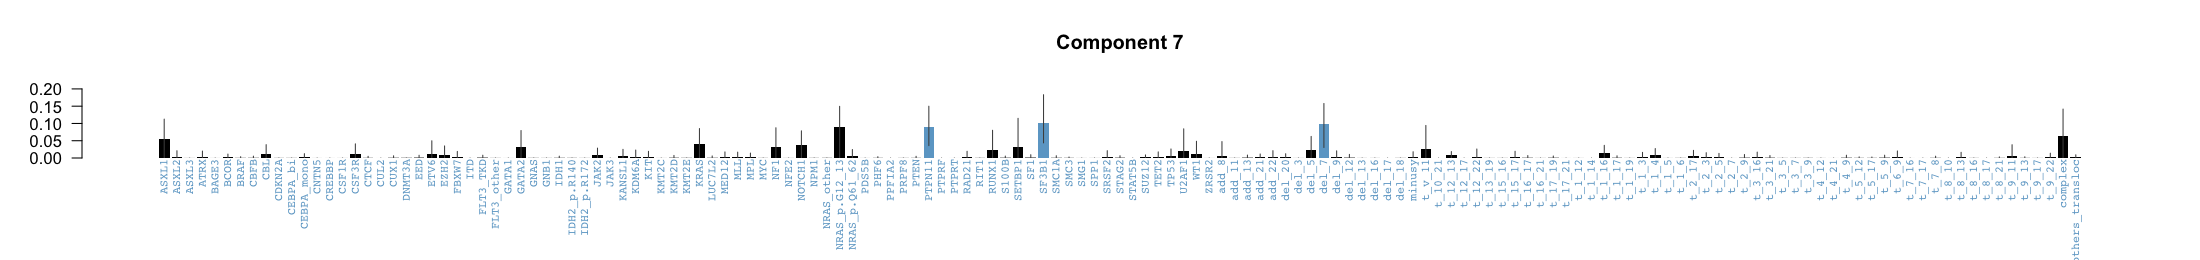

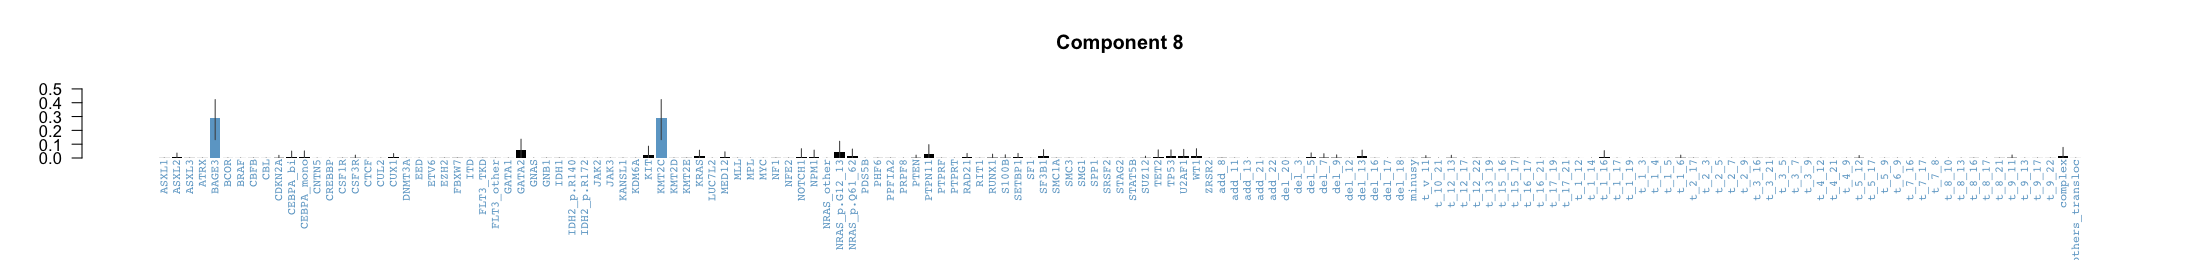

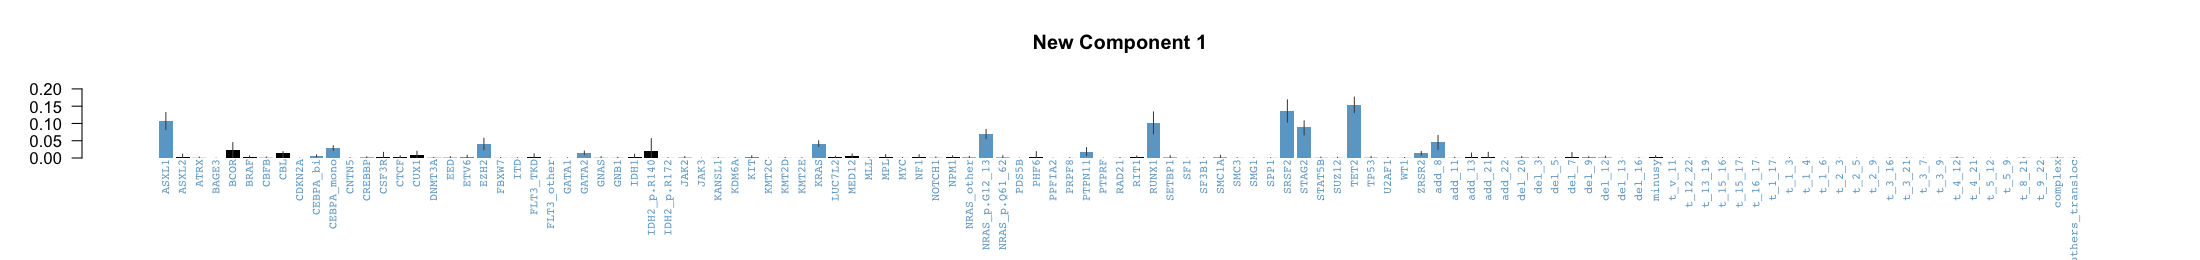

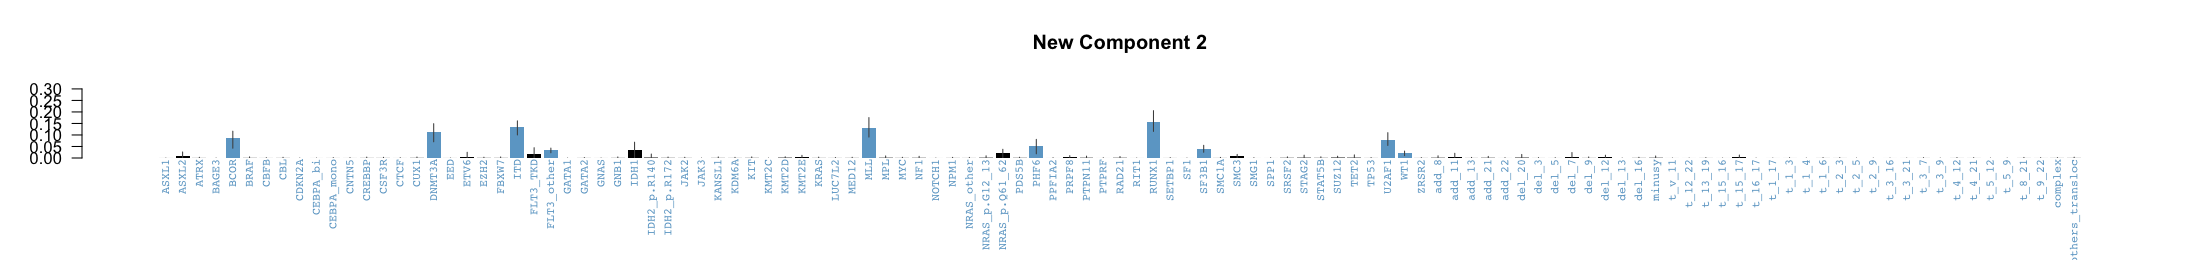

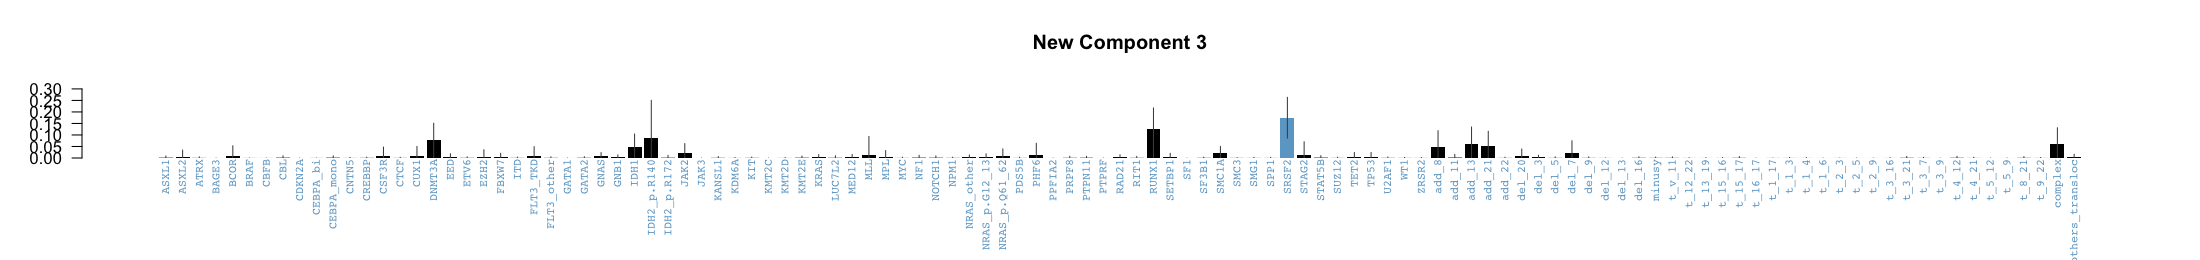

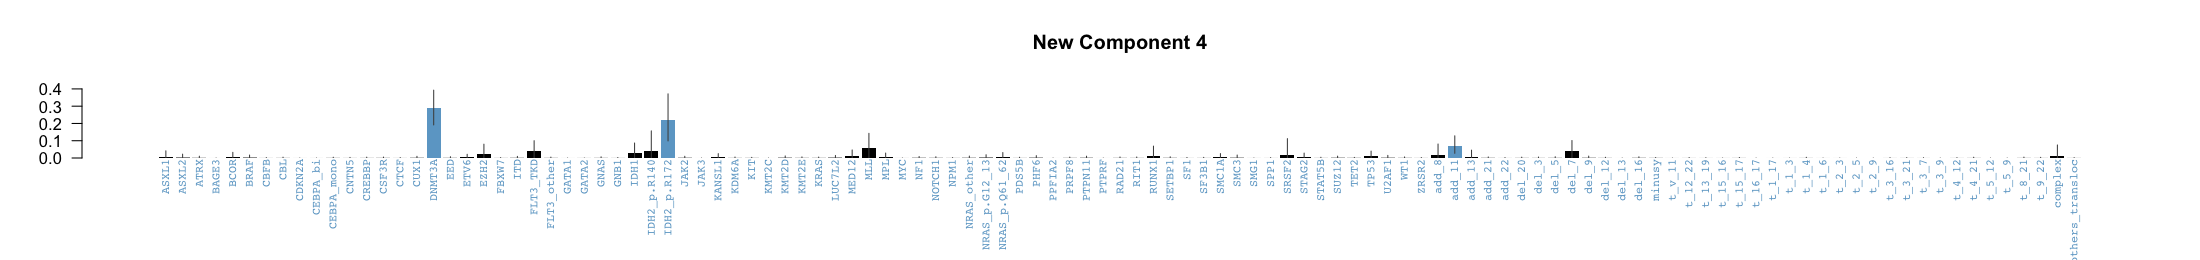

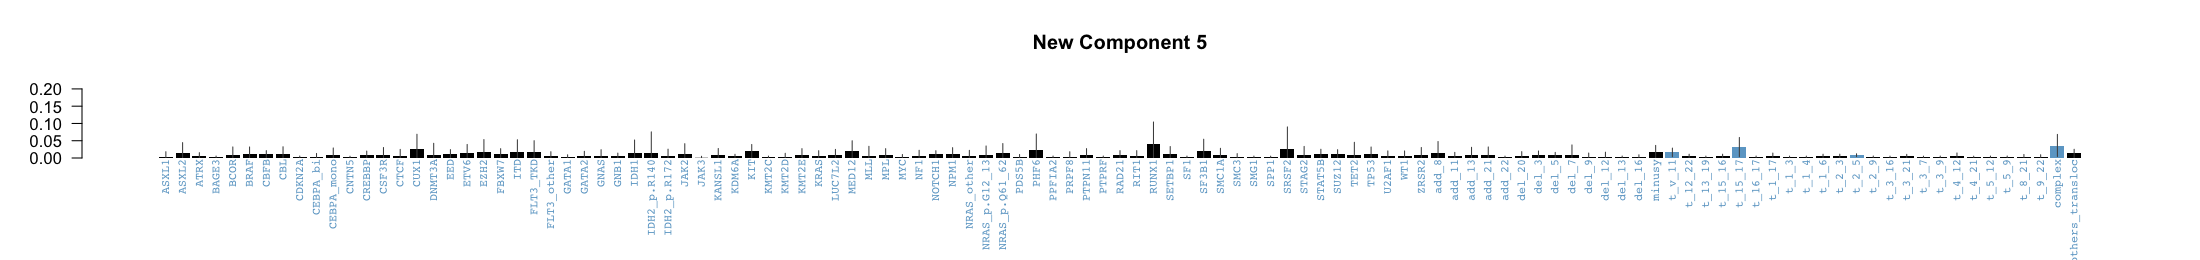

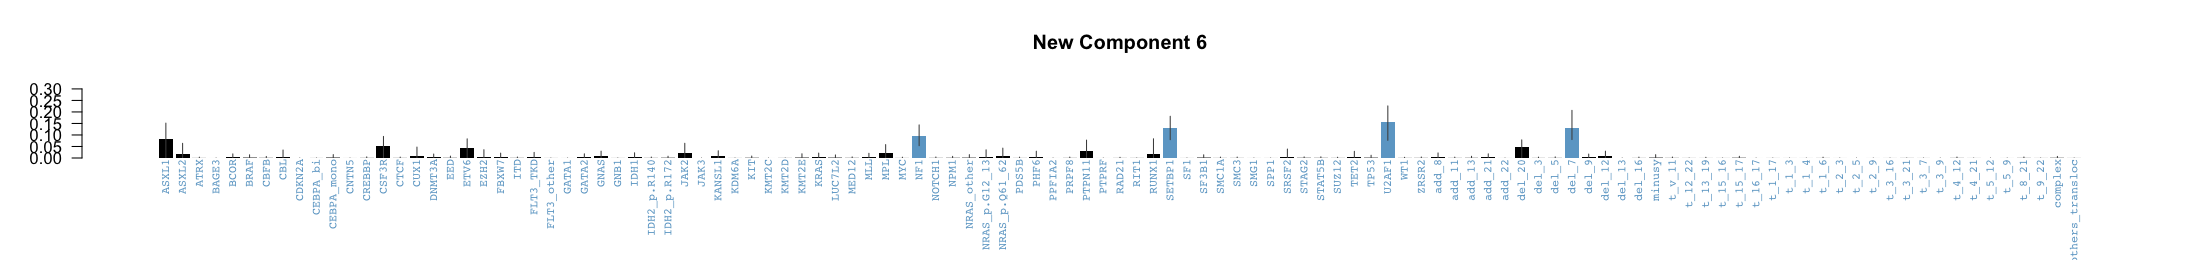

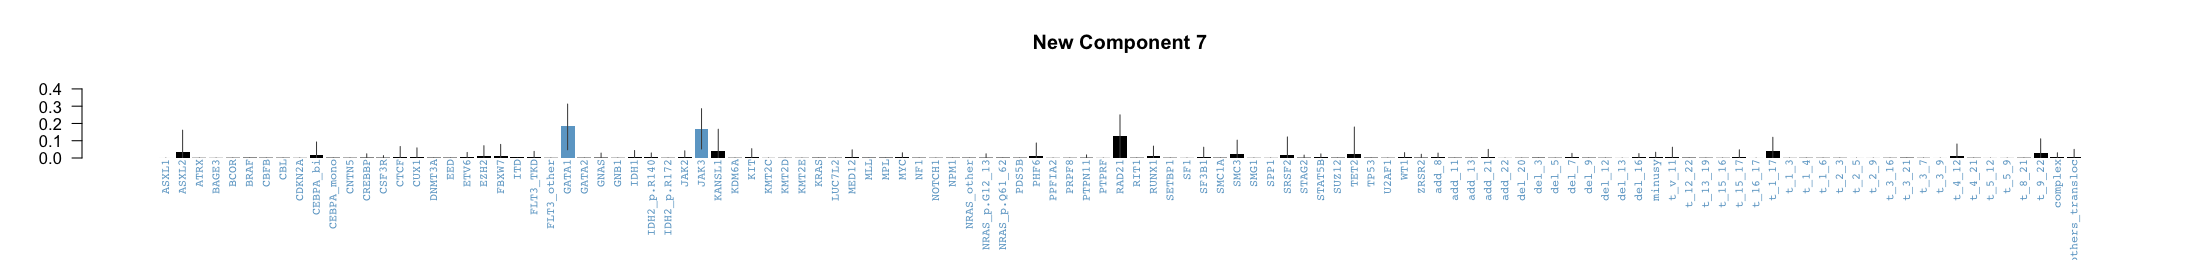

In [143]:
set_notebook_plot_size(22, 2.6)
    plot_comp_distn(multi_output_cluster_10,
                    cat_names  = colnames(df_final),
                    col        = "skyblue3",
                    col_nonsig = "black",
                    comp=c(1,3,5,6,7,8,9,10),
                    plot_title=c("Component 1","Component 2","Component 3","Component 4","Component 5","Component 6","Component 7","Component 8")
                                         )
    plot_comp_distn(multi_output_recluster_7,
                    cat_names  = colnames(df_to_recluster[colSums(df_to_recluster) > 0]),
                    col        = "skyblue3",
                    col_nonsig = "black",
                    comp=1:7,
                    plot_title=c("New Component 1","New Component 2","New Component 3","New Component 4","New Component 5","New Component 6","New Component 7"))